In [13]:
'''
2022.10.6，复现FinEvent Model
paper: from Reinforced, Incremental and Cross-lingual Event Detection From Social Messages
github address: https://github.com/RingBDStack/FinEvent
'''
'''
settings:
    matplotlib==3.5.1
    networkx==2.6.3
    numpy==1.22.0
    pandas==1.3.5
    scikit-learn==1.0.1
    scipy==1.7.3
    torch==1.10.0
    torch-cluster==1.5.9
    torch-geometric==2.0.2
    torch-scatter==2.0.9
    torch-sparse==0.6.12
    torch-spline-conv==1.2.1
    tqdm==4.62.3
    dgl==0.4.3
'''

'\nsettings:\n    matplotlib==3.5.1\n    networkx==2.6.3\n    numpy==1.22.0\n    pandas==1.3.5\n    scikit-learn==1.0.1\n    scipy==1.7.3\n    torch==1.10.0\n    torch-cluster==1.5.9\n    torch-geometric==2.0.2\n    torch-scatter==2.0.9\n    torch-sparse==0.6.12\n    torch-spline-conv==1.2.1\n    tqdm==4.62.3\n    dgl==0.4.3\n'

In [14]:
import numpy as np
import pandas as pd
import datetime

import networkx as nx
from scipy import sparse

import torch

import os
project_path = os.path.abspath(os.path.dirname(os.getcwd()))  # # 获取上级路径

In [15]:
project_path

'D:\\PycharmProjects\\GNN_Event_Detection_models'

# Data Processing

## step 1: load data

In [35]:
# generate the initial features for the messages
'''
This file generates the initial message features (please see Figure 1(b) and Section 3.2 of the paper for more details).
To leverage the semantics in the data, we generate document feature for each message,
which is calculated as an average of the pre-trained word embeddings of all the words in the message
We use the word embeddings pre-trained by en_core_web_lg, while other options, 
such as word embeddings pre-trained by BERT, are also applicable.
To leverage the temporal information in the data, we generate temporal feature for each message,
which is calculated by encoding the times-tamps: we convert each timestamp to OLE date, 
whose fractional and integral components form a 2-d vector.
The initial feature of a message is the concatenation of its document feature and temporal feature.
'''

'\nThis file generates the initial message features (please see Figure 1(b) and Section 3.2 of the paper for more details).\nTo leverage the semantics in the data, we generate document feature for each message,\nwhich is calculated as an average of the pre-trained word embeddings of all the words in the message\nWe use the word embeddings pre-trained by en_core_web_lg, while other options, \nsuch as word embeddings pre-trained by BERT, are also applicable.\nTo leverage the temporal information in the data, we generate temporal feature for each message,\nwhich is calculated by encoding the times-tamps: we convert each timestamp to OLE date, \nwhose fractional and integral components form a 2-d vector.\nThe initial feature of a message is the concatenation of its document feature and temporal feature.\n'

In [36]:
import en_core_web_lg  # spacy提供的预训练语言模型，将文本标记化已生成doc对象

In [37]:
project_path

'D:\\PycharmProjects\\GNN_Event_Detection_models'

In [38]:
load_path = project_path + '/data/FinEvent_datasets/raw dataset/'
save_path = project_path + '/result/FinEvent result/'

In [39]:
print(load_path)
print(save_path)

D:\PycharmProjects\GNN_Event_Detection_models/data/FinEvent_datasets/raw dataset/
D:\PycharmProjects\GNN_Event_Detection_models/result/FinEvent result/


In [40]:
# load dataset
p_part1 = load_path + '68841_tweets_multiclasses_filtered_0722_part1.npy'
p_part2 = load_path + '68841_tweets_multiclasses_filtered_0722_part2.npy'
# Python 中的 pickle 用于在保存到磁盘文件或从磁盘文件读取之前，对对象进行序列化和反序列化
df_np_part1 = np.load(p_part1, allow_pickle=True)  # ndarray, (35000, 16) allow_pickle, Allow loading pickled object arrays stored in npy files
df_np_part2 = np.load(p_part2, allow_pickle=True)  # ndarray, (33841, 16)
df = np.concatenate((df_np_part1, df_np_part2),axis=0) # 按行拼接; ndarray, (68841, 16)
print('loaded data.')
df = pd.DataFrame(data=df, columns=['event_id','tweet_id','text','user_id','created_at','user_loc','place_type',
                                      'place_full_name','place_country_code','hashtags','user_mentions','image_urls',
                                      'entities','words','filtered_words','sampled_words'])
print('Data converted to dataframe.')

loaded data.
Data converted to dataframe.


In [41]:
# sort date by time
df = df.sort_values(by='created_at').reset_index(drop=True)

df['date'] = [d.date() for d in df['created_at']]
# 因为graph太大，爆了内存，所以取4天的twitter data做demo，后面用nci server
init_day = df.loc[0, 'date']
df_4days = df[(df['date']>= init_day) & (df['date']<= init_day + datetime.timedelta(days=3))].reset_index()  # （11971， 18）

In [42]:
print(df_4days.shape)
print(df_4days.event_id.nunique())
print(df_4days.user_id.nunique())

(11971, 18)
89
10905


In [43]:
df_4days.head(5)

,index,event_id,tweet_id,text,user_id,created_at,user_loc,place_type,place_full_name,place_country_code,hashtags,user_mentions,image_urls,entities,words,filtered_words,sampled_words,date
0,0,394,255819992157786112,HipHop awards bout to be live!!,250870763,2012-10-10 00:00:13,,,,,[],[],[],[],"[award, live, bout, hiphop]","[award, live, bout, hiphop]",[],2012-10-10
1,1,394,255820118095978496,HIPHOP AWARDS TIME!,28026779,2012-10-10 00:00:43,SoundCloud/RaRaSupaStar,,,,[],[],[],[],"[HIPHOP, AWARDS, time]","[hiphop, awards, time]",[],2012-10-10
2,2,394,255820147489636353,Bet hiphop awards,566825483,2012-10-10 00:00:50,,,,,[],[],[],"[(Bet, GPE)]","[award, bet, hiphop]","[award, bet, hiphop]",[],2012-10-10
3,3,394,255820164023595008,BET HipHop awards is on!!!,197834311,2012-10-10 00:00:54,Saint Lucia ☀️🌴🇱🇨,,,,[],[],[],[],"[HipHop, BET, award]","[hiphop, bet, award]",[],2012-10-10
4,4,394,255820180884701184,Watchin Da BET Hiphop Awards,439490861,2012-10-10 00:00:58,"Michigan, USA",,,,[],[],[],[],"[Hiphop, Watchin, Awards, Da, BET]","[hiphop, watchin, awards, da, bet]",[],2012-10-10


In [44]:
' '.join(['apple','orange'])

'apple orange'

In [45]:
nlp = en_core_web_lg.load()
nlp(' '.join(['apple','orange'])).vector

array([-2.0110998 , -1.1696801 , -1.836925  ,  3.62435   , -0.38999498,
       -4.14575   , -2.7551    ,  4.432     , -3.6439    ,  1.56774   ,
        5.17155   , -2.1609    , -3.04495   ,  1.418985  ,  0.385655  ,
       -1.35931   ,  0.6796    , -1.65807   ,  2.4508    , -3.6395502 ,
       -1.361265  ,  3.3911    , -2.3505502 , -2.64425   , -1.4074149 ,
       -2.9309    , -2.8713    ,  0.45424998,  0.494435  ,  1.3266001 ,
       -1.1863351 , -0.805145  , -1.74835   , -2.51085   ,  1.7619    ,
       -1.5734999 ,  2.69375   ,  2.93885   ,  2.39905   , -1.84745   ,
        1.80935   ,  0.02054995, -0.08278999,  1.805665  ,  1.297785  ,
        4.19905   ,  1.0158501 , -0.53619003,  0.36874998,  0.88796496,
        1.3213301 ,  0.95765996,  0.53971505, -1.07363   , -2.0834498 ,
        1.16805   ,  0.513239  ,  1.7584    ,  2.365     ,  0.45940998,
        1.114205  ,  2.19576   , -0.65239   , -0.8655875 , -1.4635    ,
       -1.12686   , -0.654125  , -5.0572    ,  1.706955  ,  0.71

In [46]:
df.filtered_words.values

array([list(['award', 'live', 'bout', 'hiphop']),
       list(['hiphop', 'awards', 'time']),
       list(['award', 'bet', 'hiphop']), ...,
       list(['election', 'watch', 'presentation']),
       list(['anything', 'damascus', 'rock', 'kill', 'brother', 'co', 'parliament', 'get', 'man', 'anything', 'speaker', 'bombing']),
       list(['not', 'cuz', 'afford', 'idk', 'country', 'can', 'whole', 'win', 'leave', 'take', 'fam', 'romney', 'could'])],
      dtype=object)

### document embeddings

In [47]:
# calculate the embeddings of all the documents in the dataframe
# the embeddings of each document is an average of the pre-trained embeddings of all the words in it
def documents_to_features(df):
    nlp = en_core_web_lg.load()
    '''
    filtered_words: ['literature', 'nobel', 'prize', 'announce']
    features, ndarray, (68841,)。其中，单个元素是300维的向量
    [-7.0156753e-01 -2.4638350e+00  9.9222124e-01 -1.6435424e+00,  2.2959824e+00 -9.4725072e-02 ...]
    '''
    features = df.filtered_words.apply(lambda x: nlp(' '.join(x)).vector).values  # nlp生成300维向量；join函数将列表连接成字符串
    return np.stack(features, axis=0)  # stack函数沿axis邻接数组序列

### time featurs

In [48]:
# encode one times-tamp
# t_str: a string of format '2012-10-11 07:19:34'
def extract_time_feature(t_str):
    t = datetime.datetime.fromisoformat(str(t_str)) # 分别返回年月日时分秒列表
    OLE_TIME_ZERO = datetime.datetime(1899, 12, 30)
    delta = t - OLE_TIME_ZERO  # datetime.timedelta(days=41193, seconds=26374)
    return [(float(delta.days)/10000.), (float(delta.seconds)/86400)] # 86400 seconds in day

In [49]:
# encode the times-tamps of all the messages in the dateframe
def df_to_t_features(df):
    t_features = np.asarray([extract_time_feature(t_str) for t_str in df['created_at']])
    return t_features

### combined features

In [50]:
# 生成文档embedding
d_features = documents_to_features(df_4days)
print('Document features generated')

# 生成时间特征days和seconds
t_features = df_to_t_features(df_4days)  # ndarray,(11971, 2)
print('Time features generated.')

combined_features = np.concatenate((d_features, t_features), axis=1)  # （11971， 302）
print('Concatenated document features and time features.')

np.save(save_path + 'combined_features.npy', combined_features)
print('Initial features saved.')

combined_features = np.load(save_path + 'combined_features.npy')
print('Initial features loaded.')
print(combined_features.shape)

Document features generated
Time features generated.
Concatenated document features and time features.
Initial features saved.
Initial features loaded.
(11971, 302)


In [51]:
d_features.shape

(11971, 300)

In [52]:
d_features

array([[-1.5251225 , -1.2804475 , -1.67361   , ..., -0.10845   ,
        -1.2274101 , -1.1007351 ],
       [-0.08792333, -0.6259634 , -0.9900033 , ..., -2.038623  ,
        -1.2348766 ,  0.46889666],
       [-0.7383423 , -2.3103633 , -1.5300802 , ...,  1.8419999 ,
         0.25515997,  0.3208867 ],
       ...,
       [ 0.82871836,  1.8417288 , -1.7910568 , ..., -1.1083716 ,
        -0.07446832,  0.07849339],
       [-0.37493247, -0.04668879, -1.7778028 , ...,  0.10513129,
         0.5673075 ,  0.60081255],
       [-3.7216501 , -1.1870999 ,  3.4422648 , ..., -7.9503    ,
        -1.2189649 , -4.237005  ]], dtype=float32)

In [53]:
t_features.shape

(11971, 2)

In [54]:
t_features

array([[4.11920000e+00, 1.50462963e-04],
       [4.11920000e+00, 4.97685185e-04],
       [4.11920000e+00, 5.78703704e-04],
       ...,
       [4.11950000e+00, 9.96261574e-01],
       [4.11950000e+00, 9.97430556e-01],
       [4.11950000e+00, 9.99652778e-01]])

In [55]:
combined_features.shape

(11971, 302)

In [56]:
combined_features

array([[-1.52512252e+00, -1.28044748e+00, -1.67360997e+00, ...,
        -1.10073507e+00,  4.11920000e+00,  1.50462963e-04],
       [-8.79233256e-02, -6.25963390e-01, -9.90003288e-01, ...,
         4.68896657e-01,  4.11920000e+00,  4.97685185e-04],
       [-7.38342285e-01, -2.31036329e+00, -1.53008020e+00, ...,
         3.20886701e-01,  4.11920000e+00,  5.78703704e-04],
       ...,
       [ 8.28718364e-01,  1.84172881e+00, -1.79105675e+00, ...,
         7.84933940e-02,  4.11950000e+00,  9.96261574e-01],
       [-3.74932468e-01, -4.66887876e-02, -1.77780282e+00, ...,
         6.00812554e-01,  4.11950000e+00,  9.97430556e-01],
       [-3.72165012e+00, -1.18709993e+00,  3.44226480e+00, ...,
        -4.23700523e+00,  4.11950000e+00,  9.99652778e-01]])

## step 2: construct message graph

In [25]:
# construct incremental message graphs
'''
This file splits the Twitter dataset into 21 message blocks (please see Section 4.3 of the paper for more details), 
use the message blocks to construct heterogeneous social graphs (please see Figure 1(a) and Section 3.2 of the paper for more details) 
and maps them into homogeneous message graphs (Figure 1(c)).
Note that:
# 1) We adopt the Latest Message Strategy (which is the most efficient and gives the strongest performance. See Section 4.4 of the paper for more details) here, 
# as a consequence, each message graph only contains the messages of the date and all previous messages are removed from the graph;
# To switch to the All Message Strategy or the Relevant Message Strategy, replace 'G = construct_graph_from_df(incr_df)' with 'G = construct_graph_from_df(incr_df, G)' inside construct_incremental_dataset_0922().
# 2) For test purpose, when calling construct_incremental_dataset_0922(), set test=True, and the message blocks, as well as the resulted message graphs each will contain 100 messages.
# To use all the messages, set test=False, and the number of messages in the message blocks will follow Table. 4 of the paper.
'''

"\nThis file splits the Twitter dataset into 21 message blocks (please see Section 4.3 of the paper for more details), \nuse the message blocks to construct heterogeneous social graphs (please see Figure 1(a) and Section 3.2 of the paper for more details) \nand maps them into homogeneous message graphs (Figure 1(c)).\nNote that:\n# 1) We adopt the Latest Message Strategy (which is the most efficient and gives the strongest performance. See Section 4.4 of the paper for more details) here, \n# as a consequence, each message graph only contains the messages of the date and all previous messages are removed from the graph;\n# To switch to the All Message Strategy or the Relevant Message Strategy, replace 'G = construct_graph_from_df(incr_df)' with 'G = construct_graph_from_df(incr_df, G)' inside construct_incremental_dataset_0922().\n# 2) For test purpose, when calling construct_incremental_dataset_0922(), set test=True, and the message blocks, as well as the resulted message graphs each w

### graph examples

In [26]:
import networkx as nx
from scipy import sparse

from time import time
import dgl

Using backend: pytorch


In [27]:
G = nx.Graph()
tweet_list = ['t_123', 't_456', 't_789']
G.add_nodes_from(tweet_list)
for i in tweet_list:
    G.nodes[i]['tweet_id'] = True
user_list = ['Sydney', 'Beijing', 'Melbourne']
entity_list = ['me', 'bing', 'zhen']
G.add_nodes_from(user_list)
G.add_nodes_from(entity_list)

for i in entity_list:
    G.nodes[i]['entity_id'] = True
for i in user_list:
    G.nodes[i]['user_id'] = True
G.add_edges_from([['t_123', 't_456'],['t_123', 't_789'], ['t_123', 'Sydney'], ['t_456', 'Melbourne'], ['t_456', 'Beijing']])
G.add_edges_from([['t_123', 'me'], ['t_123', 'bing'], ['t_789', 'zhen']])
G.nodes['t_123']['tweet_id'] = True

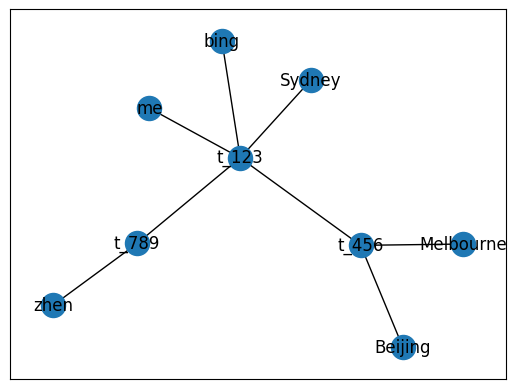

In [28]:
nx.draw_networkx(G, with_labels=True)

In [29]:
# tweet_id和user_id结构关系
tid_nodes = list(nx.get_node_attributes(G, 'tweet_id').keys())
userid_nodes = list(nx.get_node_attributes(G, 'user_id').keys())
all_nodes = list(G.nodes)
indices_tid = [all_nodes.index(x) for x in tid_nodes]
indices_userid = [all_nodes.index(x) for x in userid_nodes]
A = nx.to_numpy_matrix(G)
w_tid_userid = A[np.ix_(indices_tid, indices_userid)]
s_w_tid_userid = sparse.csr_matrix(w_tid_userid)
s_w_userid_tid = s_w_tid_userid.transpose()
homo_s_w_tid_userid = s_w_tid_userid * s_w_userid_tid

In [30]:
homo_s_w_tid_userid.toarray()

array([[1., 0., 0.],
       [0., 2., 0.],
       [0., 0., 0.]])

In [31]:
# tweet_id和entity 结构关系
tid_nodes = list(nx.get_node_attributes(G, 'tweet_id').keys())
entity_nodes = list(nx.get_node_attributes(G, 'entity_id').keys())
all_nodes = list(G.nodes)
indices_tid = [all_nodes.index(x) for x in tid_nodes]
indices_entityid = [all_nodes.index(x) for x in entity_nodes]
A = nx.to_numpy_matrix(G)
w_tid_userid = A[np.ix_(indices_tid, indices_entityid)]
s_w_tid_userid = sparse.csr_matrix(w_tid_userid)
s_w_userid_tid = s_w_tid_userid.transpose()
homo_s_w_tid_entityid = s_w_tid_userid * s_w_userid_tid

### construct heterogeneous graph

In [24]:
df.head()

,event_id,tweet_id,text,user_id,created_at,user_loc,place_type,place_full_name,place_country_code,hashtags,user_mentions,image_urls,entities,words,filtered_words,sampled_words,date
0,0,256292946331181056,Nobel prize in literature to be announced http...,47667947,2012-10-11 07:19:34,"Munich, Germany",,,,[],[],[],[],"[literature, Nobel, prize, announce]","[literature, nobel, prize, announce]",[],2012-10-11
1,0,256333064467279872,“@marvicleonen: Is it true that UP won UAAP ba...,67518107,2012-10-11 09:58:59,Philippines,,,,[],[28775032],[],"[(UP, ORG), (Next year, DATE), (Dean, PERSON)]","[Dean, Sure, year, yan, na, "", basketball, tru...","[dean, sure, year, yan, na, basketball, true, ...",[],2012-10-11
2,0,256334302034399232,"Congrats, Ateneo! Last na yan ha. Season 76 wi...",97449266,2012-10-11 10:03:54,,,,,[],[],[],"[(Ateneo, PERSON), (Season 76, PERSON)]","[yan, ☺, na, ha, different, last, Ateneo, cong...","[yan, na, ha, different, last, ateneo, congrat...",[],2012-10-11
3,0,256335853738160128,"""@SMARTPromos: SMART never wants you to be lef...",405138197,2012-10-11 10:10:04,Lost in Dreamland,,,,[],[106915372],[],"[(BIG, ORG), (BIG, ORG)]","[never, s, yan, next, na, thing, Ano, leave, t...","[never, yan, next, na, thing, ano, leave, that...",[],2012-10-11
4,0,256346272506712064,CCTV invite hints at Nobel literature prize fo...,197326414,2012-10-11 10:51:28,Taiwan(R.O.C),,,,[],[],[],"[(CCTV, ORG), (Nobel, WORK_OF_ART), (Mo Yan, P...","[invite, prize, Yan, literature, hint, CCTV, N...","[invite, prize, yan, literature, hint, cctv, n...",[],2012-10-11


In [32]:
# construct a heterogeneous graph using tweet ids, user_ids, entities and rare(sampled) words(4 modalities模态)
# if G is not None then insert new nodes to G
# 创建heterogeneous graph
def construct_graph_from_df(df, G=None):  # df: (11971, 18)
    if G is None:
        G = nx.Graph()  # 创建无向图
    for _, row in df.iterrows():  # 返回可迭代元组(index,row)
        # 1st modality: tweet_id
        tid = 't_' + str(row['tweet_id'])
        G.add_node(tid) # 一次添加一个节点，字符串作为节点id
        G.nodes[tid]['tweet_id'] = True  # 设置节点属性；right-hand side value is irrelevant for the lookup
        
        # 2nd modality: user_id
        user_ids = row['user_mentions']  # list.apend(str)
        user_ids.append(row['user_id'])
        user_ids = ['u_' + str(each) for each in user_ids]
        G.add_nodes_from(user_ids) # 添加多个节点
        for each in user_ids:
            G.nodes[each]['user_id'] = True 
        
        # 3rd modality: entities
        entities = row['entities']  # 命名实体识别的实体
#         words = ['e_' + each for each in entities]
        G.add_nodes_from(entities)
        for each in entities:
            G.nodes[each]['entity'] = True
        
        # 4th modality:sampled_words
        words = row['sampled_words']
        words = ['w_' + each for each in words]
        G.add_nodes_from(words)
        for each in words:
            G.nodes[each]['word'] = True
        
        edges =[]
        edges += [(tid, each) for each in user_ids]
        edges += [(tid, each) for each in entities]
        edges += [(tid, each) for each in words]
        G.add_edges_from(edges) # 同时添加多条边
    return G  # 30427 nodes and 40238 edges,因为以tweet_id为主，加上user_id, entities, words共有30427个

### converting hete-graph to homo-graph

In [33]:
# convert a heterogeneous social graph G to a homogeneous message graph following eq. 1 of the paper, 
# and store the sparse binary adjacency matrix of the homogeneous message graph.
# DGL(Deep Graph Library)构建更高效的图神经网络

def dgl_hetegraph_to_homograph(G, save_path=None):
    '''
    doc_embeddings: (11971, 302)
    df: (11971, 18)
    30427 nodes and 40238 edges,因为以tweet_id为主，加上user_id, entities, words共有30427个
    '''
    message = ''
    print('Start converting heterogeneous networks graph to homogeneous dgl graph.')
    message += 'Start converting heterogeneous networks graph to homogeneous dgl graph.\n'
    all_start = time()
    
    print('\tGetting a list of all nodes ...')
    message += '\tGetting a list of all nodes ...\n'
    start = time()
    all_nodes = list(G.nodes)  # 30427个
    mins = (time() - start) /60
    print('\tDone. Time elapsed: ', mins, ' mins\n')
    message += '\tDone. Time elapsed: '
    message += str(mins)
    message += ' mins\n'
    
    print('\tGetting adjacency matrix ...')
    message += '\tGetting adjacency matrix ...\n'
    start = time()
    A = nx.to_numpy_matrix(G) # Returns the graph adjacency matrix as a Numpy matrix, 整体异构图邻接矩阵，(30427, 30427)
    mins = (time() - start)/ 60
    print('\tDone. Time elapsed: ', mins, ' mins\n')
    message += '\tDone. Time elapsed: '
    message += str(mins)
    message += ' mins\n'
    
    # compute commuting matrices
    print('\tGetting lists of nodes of various types ...')
    message += '\tGetting lists of nodes of various types ...\n'
    start = time()
    '''
    all_nodes: 30427个
    tweet_id: 11971
    user_id: 11520
    entity_id: 5401
    word: 1535
    '''
    tid_nodes = list(nx.get_node_attributes(G, 'tweet_id').keys()) # get_node_attributes return node and its attributes;获得tweet_id列表
    userid_nodes = list(nx.get_node_attributes(G, 'user_id').keys()) # 同理，获得user_id列表
    word_nodes = list(nx.get_node_attributes(G, 'word').keys())
    entity_nodes = list(nx.get_node_attributes(G, 'entity').keys())
    del G  # 删除original 无向图
    mins = (time() - start)/ 60
    print('\tDone. Time elapsed: ', mins, ' mins\n')
    message += '\tDone. Time elapsed: '
    message += str(mins)
    message += ' mins\n'
    
    # 将节点转换成all_nodes中的索引index
    print('\tConverting node lists to index lists ...')
    message += '\tConverting node lists to index lists ...\n'
    start = time()
    # fine细化 the index of target nodes in the list of all nodes
    indices_tid = [all_nodes.index(x) for x in tid_nodes]        # 11971
    indices_userid = [all_nodes.index(x) for x in userid_nodes]  # 11520
    indices_word = [all_nodes.index(x) for x in word_nodes]      # 1535
    indices_entity = [all_nodes.index(x) for x in entity_nodes]  # 5401
    del tid_nodes
    del userid_nodes
    del word_nodes
    del entity_nodes
    mins = (time() -start)/60
    print('\tDone. Time elapsed: ', mins, ' mins\n')
    message += '\tDone. Time elapsed: '
    message += str(mins)
    message += ' mins\n'
    
    # ----------------tweet-user-tweet------------------
    print('\tStart constructing tweet-user-tweet commuting matrix ...')
    print('\t\t\tStart constructing tweet-user matrix ...')
    message += '\tStart constructing tweet-user-tweet commuting matrix ...\n\t\t\tStart constructing tweet-user matrix ...\n'
    start = time()
    # 笛卡尔积实际上是生成一个二维坐标矩阵，其作用是从A中抽取出x和y这两类节点的一个子邻接矩阵
    w_tid_userid = A[np.ix_(indices_tid, indices_userid)]  # np.ix_(list1, list2)生成一个笛卡尔积的映射关系；
    # return a N(indiced_tid)*N(indices_userid) matrix, representing the weight of edges between tid and userid
    mins = (time() - start)/60
    print('\t\t\tDone. Time elapsed: ', mins, ' mins\n')
    message += '\t\t\tDone. Time elapsed: '
    message += str(mins)
    message += ' mins\n'
    
    # convert to scipy sparse matrix
    print('\t\t\tConverting to sparse matrix ...')
    message += '\t\t\tConverting to sparse matrix ...\n'
    start = time()
    s_w_tid_userid = sparse.csr_matrix(w_tid_userid) # 其实就是将邻接矩阵转换成稀疏矩阵。matrix compression
    del w_tid_userid
    mins = (time() - start)/ 60
    print('\t\t\tDone. Time elapsed: ', mins, ' mins\n')
    message += '\t\t\tDone. Time elapsed: '
    message += str(mins)
    message += ' mins\n'
    
    print('\t\t\tTransposing ...')
    message += '\t\t\tTransposing ...\n'
    start = time()
    s_w_userid_tid = s_w_tid_userid.transpose()  # 转置
    mins = (time() - start) / 60
    print('\t\t\tDone. Time elapsed: ', mins, ' mins\n')
    message += '\t\t\tDone. Time elapsed: '
    message += str(mins)
    message += ' mins\n'
    
    print('\t\t\tCalculating tweet-user * user-tweet ...')
    message += '\t\t\tCalculating tweet-user * user-tweet ...\n'
    start = time()
    '''
    将meta-path: tweet-user-tweet转换成tweet-tweet矩阵，这样才能得到tweet_id0的直接邻居节点tweet_id1,2,3...，不用再隔着user关系。
    '''
    # csr_matrix, (11971, 11971)
    s_m_tid_userid_tid = s_w_tid_userid * s_w_userid_tid #  根据user_id生成tweet_id homogeneous message graph
    mins = (time() - start)/ 60
    print('\t\t\tDone. Time elapsed: ', mins, ' mins\n')
    message += '\t\t\tDone. Time elapsed: '
    message += str(mins)
    message += ' mins\n'
    
    print('\t\t\tSaving ...')
    message += '\t\t\tSaving ...\n'
    start = time()
    if save_path is not None:
        sparse.save_npz(save_path + "s_m_tid_userid_tid.npz", s_m_tid_userid_tid)
        print('sparse binary userid commuting matrix saved.')
        del s_m_tid_userid_tid
    del s_w_tid_userid
    del s_w_userid_tid
    mins = (time() - start) / 60
    print('\t\t\tDone. Time elapsed: ', mins, ' mins\n')
    message += '\t\t\tDone. Time elapsed: '
    message += str(mins)
    message += ' mins\n'
    
    # ----------tweet-ent-tweet-----------------
    print('\tStart constructing tweet-ent-tweet conmuting matrix ...')
    print('\t\t\tStart constructing tweet-ent matrix ...')
    message += '\tStart constructing tweet-ent-tweet commuting matrix ...\n\t\t\tStart constructing tweet-ent matrix ...\n'
    start = time()
    w_tid_entity = A[np.ix_(indices_tid, indices_entity)]  # 抽取tweet_id和entity的邻接矩阵
    mins = (time() - start) / 60
    message += '\t\t\tDone. Time elapsed: '
    message += str(mins)
    message += ' mins\n'
    
    # convert to scipy sparse matrix
    print('\t\t\tConverting to sparse matrix ...')
    message += '\t\t\tConver ting to sparse matrix ...\n'
    start = time()
    s_w_tid_entity = sparse.csr_matrix(w_tid_entity)  # 邻接矩阵转换成csr稀疏矩阵
    del w_tid_entity
    mins = (time() - start) / 60
    print('\t\t\tDone. Time elapsed : ', mins, ' mins\n')
    message += '\t\t\tDone. Time elapsed: '
    message += str(mins)
    message += ' mins\n'
    
    print('\t\t\tTransposing ...')
    message += '\t\t\tTransposing ...\n'
    start = time()
    s_w_entity_tid = s_w_tid_entity.transpose()  # 转置
    mins = (time() - start) / 60
    print('\t\t\tDone. Time elapsed: ', mins, ' mins\n')
    message += '\t\t\tDone. Time elapsed: '
    message += str(mins)
    message += ' mins\n'
    
    print('\t\t\tCalculating tweet-ent * ent-tweet ...')
    message += '\t\t\tCalculating tweet-ent * ent-tweet ...\n'
    start = time()
    # csr_matrix, (11971, 11971)
    s_m_tid_entity_tid = s_w_tid_entity * s_w_entity_tid  # 根据entity生成tweet_id homogeneous message graph
    mins = (time() - start) / 60
    print('\t\t\tDone. Time elapsed: ', mins, ' mins\n')
    message += '\t\t\tDone. Time elapsed: '
    message += str(mins)
    message += ' mins\n'
    
    print('\t\t\tSaving ...')
    message += '\t\t\tSaving ...\n'
    start = time()
    if save_path is not None:
        sparse.save_npz(save_path + "s_m_tid_entity_tid.npz", s_m_tid_entity_tid)
        print('Sparse binary entity commuting matrix saved.')
        del s_m_tid_entity_tid
    del s_w_tid_entity
    del s_w_entity_tid
    mins = (time() - start) / 60
    print('\t\t\tDone. Time elapsed: ', mins, ' mins\n')
    message += '\t\t\tDone. Time elapsed: '
    message += str(mins)
    message += ' mins\n'
    
    # --------tweet-word-tweet------------------
    print('\tStart constructing tweet-word-tweet commuting matrix ...')
    print('\t\t\tStart constructing tweet-word matrix ...')
    message +='\tStart constructing tweet-wrod-tweet commuting matrix ...\n\t\t\tStart constructing tweet-word matrix ...'
    start = time()
    w_tid_word = A[np.ix_(indices_tid, indices_word)]
    del A
    mins = (time() - start) / 60
    print('\t\t\tDone. Time elapsed: ', mins, ' mins\n')
    message += '\t\t\tDone. Time elapsed: '
    message += str(mins)
    message += ' mins\n'
    
    # convert to scipy sparse matrix
    print('\t\t\tConverting to Sparse matrix ...')
    message += '\t\t\tConverting to sparse matrix ...\n'
    start = time()
    s_w_tid_word = sparse.csr_matrix(w_tid_word)  # tweet_id和word稀疏矩阵
    del w_tid_word
    mins = (time() - start) / 60
    print('\t\t\tDone. Time elapsed: ', mins, ' mins\n')
    message += '\t\t\tDone. Time elapsed: '
    message += str(mins)
    message += ' mins\n'
    
    print('\t\t\tTransposing ...')
    message += '\t\t\tTransposing ...\n'
    start = time()
    s_w_word_tid = s_w_tid_word.transpose()
    mins = (time() - start) / 60
    print('\t\t\tDone. Time elapsed: ', mins, ' mins\n')
    message += '\t\t\tDone. Time elapsed: '
    message += str(mins)
    message += ' mins\n'
    
    print('\t\t\tCalculating tweet-word * word-tweet ...')
    message += '\t\t\tCalculating tweet-word * word-tweet ...\n'
    start = time()
    # csr_matrix, (11971, 11971)
    s_m_tid_word_tid = s_w_tid_word * s_w_word_tid  # 根据word生成的tweet_id homogeneous message graph
    mins = (time() - start) / 60
    print('\t\t\tDone. Time elapsed: ', mins, ' mins\n')
    message += '\t\t\tDone. Time elapsed: '
    message += str(mins)
    message += ' mins\n'
    
    print('\t\t\tSaving ...')
    message += '\t\t\tSaving ...\n'
    start = time()
    if save_path is not None:
        sparse.save_npz(save_path + "s_m_tid_word_tid.npz", s_m_tid_word_tid)
        print("Sparse binary word commuting matrix saved.")
        del s_m_tid_word_tid
    del s_w_tid_word
    del s_w_word_tid
    mins = (time() - start) / 60
    print('\t\t\tDone. Time elapsed: ', mins, ' mins\n')
    message += '\t\t\tDone. Time elapsed: '
    message += str(mins)
    message += ' mins\n'
    
    # -----------compute tweet-tweet adjacency matrix --------
    print('\tComputing tweet-tweet adjacency matrix ...')
    message += '\tComputing tweet-tweet adjacency matrix ...\n'
    start = time()
    if save_path is not None:
        s_m_tid_userid_tid = sparse.load_npz(save_path + 's_m_tid_userid_tid.npz')
        print("Sparse binary userid commuting matrix loaded.")
        s_m_tid_entity_tid = sparse.load_npz(save_path + "s_m_tid_entity_tid.npz")
        print("Sparse binary entity commuting matrix loaded.")
        s_m_tid_word_tid = sparse.load_npz(save_path + "s_m_tid_word_tid.npz")
        print("Sparse binary word commuting matrix loaded.")
    
    # 合并三个user_id, entity, word生成的tweet_id homogeneous graph
    s_A_tid_tid = s_m_tid_userid_tid + s_m_tid_entity_tid
    del s_m_tid_userid_tid
    del s_m_tid_entity_tid
    # csr_matrix, (11971, 11971)
    s_bool_A_tid_tid = (s_A_tid_tid + s_m_tid_word_tid).astype('bool')  # confirm the connect between tweets
    del s_m_tid_word_tid
    del s_A_tid_tid
    mins = (time() - start) / 60
    print('\t\t\tDone. Time elapsed: ', mins, ' mins\n')
    message += '\t\t\tDone. Time elapsed: '
    message += str(mins)
    message += ' mins\n'
    all_mins = (time() - all_start) / 60
    print('\tOver all time elapsed: ', all_mins, ' mins\n')
    message += '\tOver all time elapsed: '
    message += str(all_mins)
    message += ' mins\n'
    
    if save_path is not None:
        sparse.save_npz(save_path + "s_bool_A_tid_tid.npz", s_bool_A_tid_tid)
        print("Sparse binary adjacency matrix saved.")
        s_bool_A_tid_tid = sparse.load_npz(save_path + "s_bool_A_tid_tid.npz")
        print("Sparse binary adjacency matrix loaded.")
        
    # create correspoinding dgl graph
    G = dgl.DGLGraph(s_bool_A_tid_tid)  # 传入稀疏矩阵，转换成图神经网络
    print('We have %d nodes.' % G.number_of_nodes())
    print('We have %d edges' % G.number_of_edges())
    print()
    message += 'We have '
    message += str(G.number_of_nodes())
    message += ' nodes.'
    message += 'We have '
    message += str(G.number_of_edges())
    message += ' edges.\n'
    
    return all_mins, message

### construct offline dataset

In [34]:
save_path

'D:\\PycharmProjects\\GNN_Event_Detection_models/result/FinEvent result/'

In [35]:
# To switch to the All Message Strategy or the Relevant Message Strategy, replace 'G = construct_graph_from_df(incr_df)' with 'G = construct_graph_from_df(incr_df, G)'.
# 2) For test purpose, set test=True, and the message blocks, as well as the resulted message graphs each will contain 100 messages.
# To use all the messages, set test=False, and the number of messages in the message blocks will follow Table. 4 of the paper.
def construct_offline_dataset(df, save_path, features_embeddings, test=True):
    '''
    df: (11971, 18)
    feature_embeddings: (68841, 302)
    '''
    # If test equals true, construct the initial graph using test_ini_size_tweets
    # and increment the graph by test_incr_size tweets each day
    test_ini_size = 500
    test_incr_size = 100
    
    # save data splits for training/validate/test mask generation
    data_split = []
    # save time spent for the heterogeneous -> homogeneous conversion of each graph
    all_graph_mins = []
    message = ''
    # extract distingct dates
    distinct_dates = df.date.unique() # 所有unique的date
    print('Number of distinct dates: ', len(distinct_dates))
    message += 'Number of distinct dates: '
    message += str(len(distinct_dates))
    message += '\n'
    
    # split data by dates and construct graphs
    # first week -> initial graph (20254 tweets)
    print('Start constructing initial graph ...')
    message += '\nStart constructing initial graph ...\n'
#     ini_df = df.loc[df['date'].isin(distinct_dates[:7])]  # find top 7 days
#     if test:
#         ini_df = ini_df[: test_ini_size]  # top test_ini_size dates
    G = construct_graph_from_df(df)  # graph with 30427 nodes and 40238 edges
    path = save_path
    if path is None:
        os.mkdir(path)  # 创建目录
    graph_mins, graph_message = dgl_hetegraph_to_homograph(G, save_path=path)  # convert a heterogeneous social graph to a homogeneous message graph
    message += graph_message
    print('Initial graph saved')
    message += 'Initial graph saved\n'
    # record the totoal number of tweets
    all_graph_mins.append(graph_mins)
    # extract and save the labels of corresponding tweets
    labels = [int(each) for each in df['event_id'].values]  # 11971
    np.save(path + 'labels.npy', np.asarray(labels))  # ndarray对象，实际只创建一个指针
    print('Labels saved.')
    message += 'Labels saved.\n'
    # extract and save the features of corresponding tweets
    indices = df['index'].values.tolist()  # 11971
    x = features_embeddings[indices, :]  # (11971, 302), features是指combined_features: document_embeddings + time_features
    np.save(path + 'features_embeddings.npy', x)
    print('Features saved.')
    message += 'Features saved. \n\n'
    
#     # subsequent days -> insert tweets day by day(skip the last day because it only contains on tweet)
#     for i in range(7, len(distinct_dates) -1):
#         print('Start constructing graph', str(i - 6), '...')
#         message += '\nStart constructing graph'
#         message += str(i-6)
#         message += '...\n'
#         incr_df = df.loc[df['date']==distinct_dates[i]]
#         if test:
            
    return message, all_graph_mins

In [37]:
df.index.values

array([    0,     1,     2, ..., 68838, 68839, 68840], dtype=int64)

### run-offline dataset: 4days

In [38]:
project_path

'D:\\PycharmProjects\\GNN_Event_Detection_models'

In [39]:
import datetime
offline_save_path = project_path + '/result/FinEvent result/offline dataset/'
if not os.path.exists(offline_save_path):
    os.mkdir(offline_save_path)

# load data (68841 tweets, multiclasses filtered)
p_part1 = load_path + '68841_tweets_multiclasses_filtered_0722_part1.npy'
p_part2 = load_path + '68841_tweets_multiclasses_filtered_0722_part2.npy'
# allow_pickle: 可选，布尔值，允许使用 Python pickles 保存对象数组，Python 中的 pickle 用于在保存到磁盘文件或从磁盘文件读取之前，对对象进行序列化和反序列化。
df_np_part1 = np.load(p_part1, allow_pickle=True)  
df_np_part2 = np.load(p_part2, allow_pickle=True)
df_np = np.concatenate((df_np_part1, df_np_part2), axis=0)  # (68840, 16)
print('Data loaded.')
df = pd.DataFrame(data=df_np, columns=['event_id', 'tweet_id', 'text', 'user_id', 'created_at', 'user_loc',
                                      'place_type', 'place_full_name', 'place_country_code', 'hashtags',
                                      'user_mentions', 'image_urls', 'entities', 'words', 'filtered_words', 'sampled_words'])
print('Data converted to dataframe.')

# sort date by time
df = df.sort_values(by='created_at').reset_index(drop=True)
# append date
df['date'] = [d.date() for d in df['created_at']]
# 因为graph太大，爆了内存，所以取4天的twitter data做demo，后面用nci server
init_day = df.loc[0, 'date']
df = df[(df['date']>= init_day) & (df['date']<= init_day + datetime.timedelta(days=3))].reset_index()  # (11971, 18)
# load features
# the dimension of combined_feature is 302 in this dataset: document_features-300 + time_features-2
f = np.load(project_path + '/result/FinEvent result/combined_features.npy')  # (11971, 302)

# generate test graphs, features, and labels
message, all_graph_mins = construct_offline_dataset(df, offline_save_path, f, True)
with open(offline_save_path + 'node_edge_statistics.txt', 'w') as text_file:
    text_file.write(message)
np.save(offline_save_path + 'all_graph_min.npy', np.asarray(all_graph_mins))
print('Time spent on heterogeneous -> homogeneous graph conversions: ', all_graph_mins)

Data loaded.
Data converted to dataframe.
Number of distinct dates:  4
Start constructing initial graph ...
Start converting heterogeneous networks graph to homogeneous dgl graph.
	Getting a list of all nodes ...
	Done. Time elapsed:  1.6542275746663413e-05  mins

	Getting adjacency matrix ...
	Done. Time elapsed:  0.07835565805435181  mins

	Getting lists of nodes of various types ...
	Done. Time elapsed:  0.0017293771107991537  mins

	Converting node lists to index lists ...
	Done. Time elapsed:  0.41532753308614095  mins

	Start constructing tweet-user-tweet commuting matrix ...
			Start constructing tweet-user matrix ...
			Done. Time elapsed:  0.018926910559336343  mins

			Converting to sparse matrix ...
			Done. Time elapsed:  0.021055559317270916  mins

			Transposing ...
			Done. Time elapsed:  0.0  mins

			Calculating tweet-user * user-tweet ...
			Done. Time elapsed:  1.6756852467854817e-05  mins

			Saving ...
sparse binary userid commuting matrix saved.
			Done. Time elap

D:\Anaconda3\lib\site-packages\dgl\base.py:45: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  return warnings.warn(message, category=category, stacklevel=1)


In [40]:
save_path

'D:\\PycharmProjects\\GNN_Event_Detection_models/result/FinEvent result/'

In [41]:
df.date.unique()

array([datetime.date(2012, 10, 10), datetime.date(2012, 10, 11),
       datetime.date(2012, 10, 12), datetime.date(2012, 10, 13)],
      dtype=object)

In [42]:
save_path

'D:\\PycharmProjects\\GNN_Event_Detection_models/result/FinEvent result/'

In [43]:
df.shape

(11971, 18)

#### data_split: 4 days

In [44]:
project_path

'D:\\PycharmProjects\\GNN_Event_Detection_models'

In [1]:
# data_split保存的是message_block的数据量。e.g. data_split = [  500  ,   100, ...,  100]
#                                                         block_0  block_1    block_n
# demo: data_split
import math
dividing_point = int(df.shape[0] / 6)
data_amount = 0

data_split = []
for i in range(5):
    data_amount += dividing_point
    if i < 2:
        continue
    else:
        data_split.append(data_amount)
data_split.append(df.shape[0])
# save data_split.npy
np.save(save_path + '/offline dataset/data_split.npy', np.array(data_split))
# save edge_index_[entity, userid, word].pt 文件
data_path_temp = project_path + '/result/FinEvent result/offline dataset/'
relations = ['entity', 'userid', 'word']
for relation in relations:
    relation_edge_index = sparse_trans(os.path.join(data_path_temp, 's_m_tid_%s_tid.npz' % relation))
    torch.save(relation_edge_index, data_path_temp + '/edge_index_%s.pt' % relation)

NameError: name 'df' is not defined

In [ ]:
df.shape

In [ ]:
data_split

### run-incremental dataset

In [43]:
# acclerate the training process
import torch

data_path = save_path
relation_ids = ['entity', 'userid', 'word']
for i in range(22):
    print(i)
    save_multi_relational_graph(data_path, relation_ids, [0,i])
    print('edge index saved')
print('all edge index saved')

0


NameError: name 'save_multi_relational_graph' is not defined

# FinEvent Model Foundation

## Fundemental models

### GAT Model

In [46]:
from torch.functional import Tensor
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv  # PyG封装好的GATConv函数
from torch.nn import Linear, BatchNorm1d, Sequential, ModuleList, ReLU, Dropout

#### GAT model for mini-batch

In [47]:
class GAT(nn.Module):
    '''
    adopt this module when using mini-batch
    '''
    def __init__(self, in_dim, hid_dim, out_dim, heads) -> None:
        super(GAT, self).__init__()
        self.GAT1 = GATConv(in_channels=in_dim, out_channels=hid_dim, heads=heads, add_self_loops=False)  # 输入节点的特征维度，隐藏层节点的维度
        self.GAT2 = GATConv(in_channels=hid_dim*heads, out_channels=out_dim, add_self_loops=False)  # 隐藏层维度，输出维度
        self.layers = ModuleList([self.GAT1, self.GAT2])
        self.norm = BatchNorm1d(heads * hid_dim)  # 将num_features那一维进行归一化，防止梯度扩散
    
    def forward(self, x, adjs, device):
        for i, (edge_index, _, size) in enumerate(adjs): # 返回一个可遍历对象，同时列出数据和数据下标
            # x: Tensor, edge_index: Tensor
            x, edge_index = x.to(device), edge_index.to(device)
            x_target = x[:size[1]]  # Target nodes are always placed first
            x = self.layers[i]((x,x_target), edge_index)
            if i == 0:
                x = self.norm(x)  # 归一化操作，防止梯度散射
                x = F.elu(x)  # 非线性激活函数elu
                x = F.dropout(x, training=self.training)
            del edge_index
        return x

#### Intra_AGG

In [48]:
# GAT model
class Intra_AGG(nn.Module):  # intra-aggregation
    def __init__(self, GAT_args):
        super(Intra_AGG, self).__init__()
        in_dim, hid_dim, out_dim, heads = GAT_args
        self.gnn = GAT(in_dim, hid_dim, out_dim, heads)
    
    def forward(self, x, adjs, device):
        x = self.gnn(x, adjs, device)
        return x

#### Inter_AGG

In [49]:
# mlp model
class Inter_AGG(nn.Module):  # inter-aggregation
    def __init__(self, mlp_args=None):
        super(Inter_AGG, self).__init__()
        if mlp_args is not None:
            hid_dim, out_dim = mlp_args
            self.mlp = nn.Sequential(
                        Linear(hid_dim, hid_dim),
                        BatchNorm1d(hid_dim),
                        ReLU(inplace=True),
                        Dropout(),
                        Linear(hid_dim, out_dim),
                        )
    def forward(self, features, thresholds, inter_opt):
        batch_size = features[0].size(0)
        features = torch.transpose(features, dim0=0, dim1=1)
        if inter_opt == 'cat_wo_avg':
            features = features.reshape(batch_size, -1)
        elif inter_opt == 'cat_w_avg':
            # weighted average and concatenate
            features = torch.mul(features, thresholds).reshape(batch_size, -1)
        elif inter_opt == 'cat_w_avg_mlp':
            features = torch.mul(features, thresholds).reshape(batch_size, -1)
            features = self.mlp(features)
        elif inter_opt == 'cat_wo_avg_mlp':
            features = torch.mul(features, thresholds).reshape(batch_size, -1)
            features = self.mlp(features)
        elif inter_opt == 'add_wo_avg':
            features = features.sum(dim=1)
        elif inter_opt == 'add_w_avg':
            features = torch.mul(features, thresholds).sum(dim=1)
        return features
            

### TripletLoss

In [50]:
from itertools import combinations
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import gc

In [51]:
# Applies an average on seq, of shape(nodes, features)
class AvgReadout(nn.Module):
    def __init__(self):
        super(AvgReadout, self).__init__()
    def forward(self, seq):
        return torch.mean(seq, 0)

In [52]:
class Discriminator(nn.Module):  # 鉴别器
    def __init__(self, n_h):
        super(Discriminator, self).__init__()
        self.f_k = nn.Bilinear(n_h, n_h, 1)  # 双向现行变换x1*A*x2
        for m in self.modules():
            self.weights_init(m)
    
    def weights_init(self, m):
        if isinstance(m, m.Bilinear):
            torch.nn.init.xavier_uniform_(m.weight.data)  # 权值初始化方法，均分分布
            if m.bias is not None:
                m.bias.data.fill_(0.0)
    
    def forward(self, c, h_pl, h_mi, s_bias1=None, s_bias2=None):
        c_x = torch.unsqueeze(c, 0)
        c_x = c_x.expand_as(h_pl)  # torch.randn(size*)生成size维数组；expand是扩展到size_new数组；expand_as是扩展到像y的数组
        sc_1 = torch.squeeze(self.f_k(h_pl, c_x), 1)
        sc_2 = torch.squeeze(self.f_k(h_mi, c_x), 1)
        if s_bias1 is not None:
            sc_1 += s_bias1
        if s_bias2 is not None:
            sc_2 += s_bias2
        logits = torch.cat((sc_1, sc_2), 0)
        return logits

#### triplet_loss_function

In [53]:
# 计算triplet_loss损失函数
class OnlineTripletLoss(nn.Module):
    '''
    Online Triplets loss
    Takes a batch of embeddings and corresponding labels
    Triplets are generated using triplet_selector objects that take embeddings and targets and return indices of triplets
    '''
    def __init__(self, margin, triplet_selector):
        super(OnlineTripletLoss, self).__init__()
        self.margin = margin
        self.triplet_selector = triplet_selector  # selector选择器对象，含有get_triplets方法
    
    def forward(self, embeddings, target):
        triplets = self.triplet_selector.get_triplets(embeddings, target)  # 根据embeddings和labels返回最大loss index list
        # if embeddings.is_cuda():
        #     triplets = triplets.cuda()
        # embeddings矩阵索引是单个元素，取行向量，多个行向量又组成矩阵！！
        ap_distances = (embeddings[triplets[:,0]] - embeddings[triplets[:,1]]).pow(2).sum(1) # .pow(.5); 
        an_distances = (embeddings[triplets[:,0]] - embeddings[triplets[:,2]]).pow(2).sum(1) # .pow(.5)
        losses = F.relu(ap_distances - an_distances + self.margin)
        
        return losses.mean(), len(triplets)

In [54]:
np.array([1,2,3]).mean()

2.0

In [55]:
class TripletSelector:
    '''
    Implementation should return indices of anchors, positive and negative samples
    return np array of shape [N_triplets * 3]
    '''
    def __init__(self):
        pass
    def get_triplets(self, embeddings, labels):
        raise NotImplementedError  # 如果这个方法没有被子类重写，但是调用了，就会报错。

In [56]:
labels_demo = [1,0,0,1,2,3]
for label in set(labels_demo):
    label_mask_demo = (labels_demo == label)
    label_indices_demo = np.where(label_mask_demo)[0]
    break

In [57]:
label_indices_demo

array([], dtype=int64)

In [58]:
label_mask_demo

False

In [59]:
anchor_positives = np.array([(0, 2), (0, 3), (2, 3)])
anchor_positives[:,0]

array([0, 0, 2])

In [60]:
np.array([0,2])[0]

0

In [61]:
matrix_demo = torch.randn(4,4)

In [62]:
matrix_demo

tensor([[ 1.6280,  2.0057, -0.6209,  0.0762],
        [ 0.6341,  1.5761, -0.1927,  0.7800],
        [ 2.2200, -0.5745,  1.6787, -1.3785],
        [-1.6311, -1.0245,  0.4135,  1.5535]])

In [63]:
matrix_demo[np.array([2,1,3])]

tensor([[ 2.2200, -0.5745,  1.6787, -1.3785],
        [ 0.6341,  1.5761, -0.1927,  0.7800],
        [-1.6311, -1.0245,  0.4135,  1.5535]])

In [64]:
# 矩阵计算
def distance_matrix_computation(vectors):
    distance_matrix=-2*vectors.mm(torch.t(vectors))+vectors.pow(2).sum(dim=1).view(1,-1)+vectors.pow(2).sum(dim=1).view(-1,1)
    return distance_matrix

In [65]:
label_demo = torch.tensor([2,1,2,3]).data.numpy()

#### triplet_loss_max_index

In [66]:
# 具体实现三元损失函数triplets_loss，返回某标签下ith元素和jth元素，其最大loss对应的其他标签元素索引

class FunctionNegativeTripletSelector(TripletSelector):
    '''
    For each positive pair, takes the hardes negative sample (with the greatest triplet loss value) to create a triplet
    Margin should match the margin userd in triplet loss.
    negative_selection_fn should take array of loss_values for a given anchor-positive pair and all negative samples
    and return a negative index for that pair
    '''
    def __init__(self, margin, negative_selection_fn, cpu=True):
        super(FunctionNegativeTripletSelector, self).__init__()
        self.cpu = cpu
        self.margin = margin
        self.negative_selection_fn = negative_selection_fn  # 返回loss_values最大元素值的index的selector
    
    def get_triplets(self, embeddings, labels):
        if self.cpu:
            embeddings = embeddings.cpu()
        distance_matrix = distance_matrix_computation(embeddings)  # 计算distance matrix
        distance_matrix = distance_matrix.cpu()  
        
        labels = labels.cpu().data.numpy()
        triplets = []
        
        # embedding计算的distance matrix与labels计算loss，取最大loss_index
        # 对于每个标签label
        for label in set(labels):
            label_mask = (labels == label)  # numpy array([True, False, True, True])
            label_indices = np.where(label_mask)[0]  # 标签索引, label_index, array([0, 2, 3], dtype=int64)
            if len(label_indices) < 2:
                continue
            negative_indices = np.where(np.logical_not(label_mask))[0]  # 其他标签索引, not_label_index, array([1], dtype=int64)
            anchor_pos_list = list(combinations(label_indices, 2)) # 2个元素的标签索引组合, [(0, 2), (0, 3), (2, 3)]
            anchor_pos_list = np.array(anchor_pos_list)  # 转换成np.array才能进行slice切片操作
            
            # 按照anchor_positive index从距离矩阵中抽取distance；0-index，array([0, 0, 2]);
            # 提取标签label的i-element与j-element距离。
            anchor_p_distances = distance_matrix[anchor_pos_list[:,0], anchor_pos_list[:,1]] #类似组成坐标，tensor([-1.1761,-0.8381,0.0099])
            for anchor_positive, ap_distance in zip(anchor_pos_list, anchor_p_distances): # 每个标签下，元素组合、元素距离
                # 0表示ith元素到各个其他标签元素的距离。
                # 同一标签下(ith,jth)距离 - ith元素到其他标签元素的距离 + self.margin边际收益
                loss_values = ap_distance - distance_matrix[  
                    torch.LongTensor(np.array([anchor_positive[0]])), torch.LongTensor(negative_indices)] + self.margin
                loss_values = loss_values.data.cpu().numpy()
                hard_neg_max_index = self.negative_selection_fn(loss_values)  # hard返回最大loss的索引
                if hard_neg_max_index is not None:  # if 最大loss值非空，则返回其他标签元素的索引
                    hard_negative = negative_indices[hard_neg_max_index] 
                    # 对于谋标签下ith元素和jth元素，其最大loss对应的其他标签元素索引
                    triplets.append([anchor_positive[0], anchor_positive[1], hard_negative]) 
        
        if len(triplets) == 0:
            triplets.append([anchor_positive[0], anchor_positive[1], negative_indices[0]])
        
        triplets = np.array(triplets)
        return torch.LongTensor(triplets)

In [67]:
# 随机-loss随机负值
def random_hard_negative(loss_values):
    hard_negatives = np.where(loss_values > 0)[0]
    return np.random.choice(hard_negatives) if len(hard_negatives) > 0 else None

In [68]:
# 硬-loss最大负值
def hardest_negative(loss_values):
    hard_negative = np.argmax(loss_values)
    return hard_negative if loss_values[hard_negative] > 0 else None

#### hard_tri-loss_selection

In [69]:
# 硬三元损失函数
def HardestNegativeTripletSelector(margin, cpu=False):
    return FunctionNegativeTripletSelector(margin=margin, negative_selection_fn=hardest_negative, cpu=cpu)

#### random_tri-loss_selection

In [70]:
# 随机三元损失函数
def RandomNegativeTripletSelector(margin, cpu=False):
    return FunctionNegativeTripletSelector(margin=margin, negative_selection_fn=random_hard_negative, cpu=cpu)

In [71]:
torch.randn(2, 1, 1)

tensor([[[ 0.6396]],

        [[-1.4468]]])

In [72]:
torch.randn(2, 3, 3)

tensor([[[ 0.5154,  0.0506,  0.3423],
         [ 0.8576, -0.1571,  1.4457],
         [-0.6813, -1.2860, -1.3743]],

        [[-0.1772, -0.4001, -0.8635],
         [-1.0015, -2.0096,  0.1044],
         [-1.8040,  0.8419,  0.6068]]])

### NeighborRL

In [73]:
from typing import Any, Dict
import numpy as np
import torch
from torch.functional import Tensor
import math
import os

#### cal_similarity_node_edge

In [74]:
def cal_similarity_node_edge(multi_r_data, features, save_path=None):
    '''
    This is used to culculate the similarity between node and its neighbors in advance 
    in order to avoid the repetitive computation.
    Args:
        multi_r_data ([type]): [description]
        features ([type]): [description]
        save_path ([type], optional): [description]. Defaults to None.
    '''
    relation_config: Dict[str, Dict[int, Any]] = {}
    for relation_id, r_data in enumerate(multi_r_data):
        node_config: Dict[int, Any] = {}
        r_data: Tensor
        unique_nodes = r_data[1].unique()
        num_nodes = unique_nodes.size(0)
        for node in range(num_nodes):
            # get neighbors' index
            neighbors_idx = torch.where(r_data[1]==node)[0]
            # get neghbors
            neighbors = r_data[0, neighbors_idx]
            num_neighbors = neighbors.size(0)
            neighbors_features = features[neighbors, :]
            target_features = features[node, :]
            # calculate enclidean distance with broadcast
            dist: Tensor = torch.norm(neighbors_features - target_features, p=2, dim=1)  # torch.norm求a列维度(dim指定)的2(p指定)范数(长度)
            # smaller is better and we use 'top p' in our paper
            # (threshold * num_neighbors) see RL_neighbor_filter for details
            sorted_neighbors, sorted_index = dist.sort(descending=False)
            node_config[node] = {'neighbors_idx': neighbors_idx,
                                'sorted_neighbors': sorted_neighbors,
                                'sorted_index': sorted_index,
                                'num_neighbors': num_neighbors}
        relation_config['relation_%d' % relation_id] = node_config
    if save_path is not None:
        print(save_path)
        save_path = os.path.join(save_path, 'relation_config.npy')
        np.save(save_path, relation_config)

#### RL_neighbor_filter

In [75]:
# 返回filtered neighbor index
def RL_neighbor_filter(multi_r_data, RL_thtesholds, load_path):
    load_path = os.path.join(load_path, 'relation_config.npy')
    relation_config = np.load(load_path, allow_pickle=True)
    relation_config = relation_config.tolist()
    relations = list(relation_config.keys())
    multi_remain_data = []
    
    for i in range(len(relations)):
        edge_index: Tensor = multi_r_data[i]
        unique_nodes = edge_index[1].unique()
        num_nodes = unique_nodes.size(0)
        remain_node_index = torch.tensor([])
        for node in range(num_nodes):
            # extract config
            neighbors_idx = relation_config[relations[i]][node]['neighbors_idx']
            num_neighbors = relation_config[relations[i]][node]['num_neighbors']
            sorted_neighbors = relation_config[relations[i]][node]['sorted_neighbors']
            sorted_index = relation_config[relations[i]][node]['sorted_index']
            
            if num_neighbors < 5:
                remain_node_index = torch.cat((remain_node_index, neighbors_idx))
                continue  # add limitations
            
            threshold = float(RL_thtesholds[i])
            
            num_kept_neighbors = math.ceil(num_neighbors * threshold) + 1
            num_kept_neighbors_idx = neighbors_idx[sorted_index[:num_kept_neighbors]]
            filtered_neighbors_idx = neighbors_idx[sorted_index[:num_kept_neighbors]]
            remain_node_index = torch.cat((remain_node_index, filtered_neighbors_idx))
            
        remain_node_index = remain_node_index.type('torch.LongTensor')
        edge_index = edge_index[:, remain_node_index]
        multi_remain_data.append(edge_index)
    
    return multi_remain_data

# FinEvent Model

## gen_dataset

In [78]:
from scipy.sparse.coo import coo_matrix
from scipy.sparse.csr import csr_matrix
from scipy import sparse

from torch_geometric.data import Data
from torch_sparse.tensor import SparseTensor
# from .utils import generateMasks, gen_offline_masks，是指从utils.py文件中导入函数: generatemasks, gen_offline_masks.

### sparse_trans

In [79]:
# relations_ids = ['entity', 'userid', 'word'],分别读取这三个文件
def sparse_trans(datapath = 'incremental_0808/0/s_m_tid_userid_tid.npz'):
    relation = sparse.load_npz(datapath)  # (11971, 11971)
    all_edge_index = torch.tensor([], dtype=int)
    for node in range(relation.shape[0]):
        neighbor = torch.IntTensor(relation[node].toarray()).squeeze()  # IntTensor是torch定义的7中cpu tensor类型之一；
                                                                        # squeeze对数据维度进行压缩，删除所有为1的维度
        # del self_loop in advance
        neighbor[node] = 0
        neighbor_idx = neighbor.nonzero()  # 返回非零元素的索引
        neighbor_sum = neighbor_idx.size(0)  # 表示第0维度的数据量
        loop = torch.tensor(node).repeat(neighbor_sum, 1)  # repeat表示沿着指定的维度重复tensor的次数
        edge_index_i_j = torch.cat((loop, neighbor_idx), dim=1).t()  # cat表示拼接；t表示对二维矩阵进行转置
        self_loop = torch.tensor([[node], [node]])
        all_edge_index = torch.cat((all_edge_index, edge_index_i_j, self_loop), dim=1)
        del neighbor, neighbor_idx, loop, self_loop, edge_index_i_j
    return all_edge_index

In [80]:
def coo_trans(datapath = 'incremental_0808/0/s_m_tid_userid_tid.npz'):
    relation: csr_matrix = sparse.load_npz(datapath)
    relation: coo_matrix = relation.tocoo()
    sparse_edge_index = torch.LongTensor([relation.row, relation.col])  # sparse稀疏矩阵用三元组(row,col,data)来存储非零元素信息
    return sparse_edge_index

In [81]:
def create_dataset(loadpath, relation, mode):
    features = np.load(os.path.join(loadpath, str(mode[1]), 'features_embeddings.npy'))
    features = torch.FloatTensor(features)
    print('features laoded')
    labels = np.load(os.path.join(loadpath, str(mode[1]), 'labels.npy'))
    print('labels loaded')
    labels = torch.LongTensor(labels)
    relation_edge_index = coo_trans(os.path.join(loadpath, str(mode[1]), 's_m_tid_%s_tid.npz' % relation))
    print('edge index laoded')
    data = Data(x=features, edge_index=relation_edge_index, y=labels)
    data_split = np.load(os.path.join(loadpath, 'data_split.npy'))
    train_i, i = mode[0], mode[1]
    if train_i == i:
        data.train_mask, data.val_mask = generateMasks(len(labels), data_split, train_i, i)
    else:
        data.test_mask = generateMasks(len(labels), data_split, train_i, i)
    return data

### create homodataset

In [82]:
'''
mode: (train_i, i)
message block 0-train_i, as training dataset
random selection from training dataset, as validation dataset
other message blocks between train_i and i, having no labels
message block i, as test dataset
'''
# 返回training, validation, test data
def create_homodataset(loadpath, mode, valid_percent=0.2):
    features = np.load(os.path.join(loadpath, 'features_embeddings.npy'))  # features embeddings
    features = torch.FloatTensor(features)
    print('features loaded')
    labels = np.load(os.path.join(loadpath, 'labels.npy'))
    print('labels loaded')
    labels = torch.LongTensor(labels)
    
    data = Data(x=features, edge_index=None, y=labels)  # torch_geometric提供的图数据类型Data，x表示tensor矩阵，
                                                        # 形状为[num_nodes, num_node_features]; 
                                                        # edge_index表示coo格式的图的边关系，形状为[2, num_edge]
    data_split = np.load(os.path.join(loadpath, 'data_split.npy'))
    # load number of message in each blocks
    # e.g. data_split = [  500  ,   100, ...,  100]
    #                    block_0  block_1    block_n
    train_i, i = mode[0], mode[1]
    if train_i == i:
        data.train_mask, data.val_mask = generateMasks(len(labels), data_split, train_i, i, valid_percent)
    else:
        data.test_mask = generateMasks(len(labels), data_split, train_i, i)
    return data

In [83]:
df.shape

(11971, 18)

In [84]:
save_path

'D:\\PycharmProjects\\GNN_Event_Detection_models/result/FinEvent result/'

### create_offline_homodataset

In [85]:
def create_offline_homodataset(loadpath, mode):
    features = np.load(os.path.join(loadpath, 'features_embeddings.npy'))
    features = torch.FloatTensor(features)
    print('features loaded')
    labels = np.load(os.path.join(loadpath, 'labels.npy'))
    print('labels loaded')
    labels = torch.LongTensor(labels)
    data = Data(x=features, edge_index=None, y=labels)
    data.train_mask, data.val_mask, data.test_mask = gen_offline_masks(len(labels))
    
    return data

### create_multi_relational_graph

In [86]:
# get edge_index_relation data
def create_multi_relational_graph(loadpath, relations, mode):
    multi_relation_edge_index = [torch.load(loadpath + '/edge_index_%s.pt' % relation) for relation in relations]
    print('sparse trans...')
    print('edge index loaded')
    
    return multi_relation_edge_index

In [87]:
np.ix_([1,5,7,2],[0,3,1,2])

(array([[1],
        [5],
        [7],
        [2]]),
 array([[0, 3, 1, 2]]))

In [88]:
def save_multi_relational_graph(loadpath, relations, mode):
    for relation in relations:
        relation_edge_index = sparse_trans(os.path.join(loadpath, str(mode[1]), 's_m_tid_%s_tid.npz' % relation))
        torch.save(relation_edge_index, loadpath + '/' + str(mode[1]) + '/edge_index_%s.pt' % relation)

In [89]:
save_path

'D:\\PycharmProjects\\GNN_Event_Detection_models/result/FinEvent result/'

### generateMasks

In [90]:
# 返回training，validation, test的索引indices
def generateMasks(length, data_split, train_i, i, validation_percent=0.2, save_path=None, remove_absolete=2):
    '''    
    Intro:
    This function generates train and validation indices for initial/maintenance epochs and test indices for inference(prediction) epochs
    If remove_obsolete mode 0 or 1:
    For initial/maintenance epochs:
    - The first (train_i + 1) blocks (blocks 0, ..., train_i) are used as training set (with explicit labels)
    - Randomly sample validation_percent of the training indices as validation indices
    For inference(prediction) epochs:
    - The (i + 1)th block (block i) is used as test set.
    
    Note that other blocks (block train_i + 1, ..., i - 1) are also in the graph (without explicit labels, only their features and structural info are leveraged)

    :param length: the length of label list
    :param data_split: loaded splited data (generated in custom_message_graph.py)
    :param train_i, i: flag, indicating for initial/maintenance stage if train_i == i and inference stage for others
    :param validation_percent: the percent of validation data occupied in whole dataset
    :param save_path: path to save data
    :param num_indices_to_remove: number of indices ought to be removed
    :returns train indices, validation indices or test indices
    '''
    # step1: verify total number of nodes
    assert length == data_split[i] # 500
    
    # step2.0: if is in initial/maintenance epochs, generate train and validation indices
    if train_i == i:
        # step3: randomly shuffle the graph indices
        train_indices = torch.randperm(length)  # 返回一个随机打散的0-n-1 tensor数组
        # step4: get total number of validation indices
        n_validation_samples = int(length * validation_percent)
        # step5: sample n_validation_samples validation indices and use the rest as training indices
        validation_indices = train_indices[:n_validation_samples]
        train_indices = train_indices[n_validation_samples:]
        # step6: save indices
        if save_path is not None:
            torch.save(train_indices, save_path + '/train_indices.pt')
            torch.save(validation_indices, save_path + '/validation_indices.pt')
        return train_indices, validation_indices
    # step2.1: if is in inference(prediction) epochs, generate test indices
    else:
        test_indices = torch.arange(0, (data_split[i]), dtype=torch.long)
        if save_path is not None:
            torch.save(test_indices, save_path + '/test_indices.pt')
        return test_indices

In [91]:
save_path

'D:\\PycharmProjects\\GNN_Event_Detection_models/result/FinEvent result/'

### gen_offline_masks

In [92]:
def gen_offline_masks(length, validation_percent=0.2, test_percent=0.1):
    test_length = int(length * test_percent)
    valid_length = int(length * validation_percent)
    train_length = length - valid_length - test_length
    
    samples = torch.randperm(length)  # 返回随机打散的0~n-1的tensor数组
    train_indices = samples[:train_length]
    valid_indices = samples[train_length: train_length + valid_length]
    test_indices = samples[train_length + valid_length:]
    
    return train_indices, valid_indices, test_indices

### mysampler

In [93]:
import copy
from typing import List, Optional, Tuple, NamedTuple, Union, Callable
from scipy import sparse
import random

import torch
from torch import Tensor
from torch_sparse import SparseTensor
from torch_geometric.loader import NeighborSampler, RandomNodeSampler

In [95]:
# NeighborSampler返回结果：batch_size, n_id,adjs(edge_index,e_id,size)
class MySampler(object):
    def __init__(self, sampler) -> None:
        super().__init__()
        self.sampler = sampler
    
    def sample(self, multi_relational_edge_index: List[Tensor], node_idx, sizes, batch_size):
        if self.sampler == 'RL_sampler':
            return self._RL_sample(multi_relational_edge_index, node_idx, sizes, batch_size)
        elif self.sampler == 'randdom_sampler':
            return self._random_sample(multi_relational_edge_index, node_idx, batch_size)
        elif self.sampler == 'const_sampler':
            return self._const_sample(multi_relational_edge_index, node_idx, batch_size)
    
    def _RL_sample(self, multi_relational_edge_index: List[Tensor], node_idx, sizes, batch_size):
        outs = []
        all_n_ids = []
        for id, edge_index in enumerate(multi_relational_edge_index):  # 返回数据和数据下标
            loader = NeighborSampler(edge_index=edge_index, 
                                     sizes=sizes, 
                                     node_idx=node_idx, 
                                     return_e_id=False,
                                     batch_size=batch_size, 
                                     num_workers=0)  
            for id, (_, n_ids, adjs) in enumerate(loader):  # NeighborSampler返回结果：batch_size, n_id,adjs(edge_index,e_id,size)
                outs.append(adjs)  # adjs包括：edge_index, bipartite子图中source节点到target节点的边，e_id是在原始图中的id，size是子图shape
                all_n_ids.append(n_ids)  # n_ids是包含所有在L层卷积中遇到的节点的list，且target节点在n_ids前几位
            
            assert id == 0  # 断言，条件为false时触发，中断程序
        return outs, all_n_ids
    
    def _random_sample(self, multi_relational_edge_index: List[Tensor], node_idx, batch_size):
        outs = []
        all_n_ids = []
        sizes = [random.randint(10,100), random.randint(10,50)]
        for edge_index in multi_relational_edge_index:
            loader = NeighborSampler(edge_index=edge_index, sizes=sizes, node_idx=node_idx, return_e_id=False,
                                    batch_size=batch_size, num_workers=0)
            for id, (_, n_ids, adjs) in enumerate(loader):
                outs.append(adjs)
                all_n_ids.append(n_ids)
            assert id == 0
        return outs, all_n_ids

    def _const_sample(self, multi_relational_edge_index: List[Tensor], node_idx, batch_size):
        outs = []
        all_n_ids = []
        sizes = [25, 15]
        for edge_index in multi_relational_edge_index:
            loader = NeighborSampler(edge_index=edge_index, sizes=sizes, node_idx=node_idx, return_e_id=False,
                                    batch_size=batch_size, num_workers=0)
            for id, (_, n_ids, adjs) in enumerate(loader):
                outs.append(adjs)
                all_n_ids.append(n_ids)
            assert id == 0
        return outs, all_n_ids

### save_embeddings

In [96]:
def save_embeddings(extracted_features, save_path):
    torch.save(extracted_features, save_path + '/final_embeddings.pt')
    print('extracted features saved.')

## MarGNN model

In [2]:
import torch
import torch.nn as nn
from torch.functional import Tensor
import time

In [3]:
# MarGNN model 返回node embedding representation
class MarGNN(nn.Module):
    def __init__(self, GNN_args, num_relations, inter_opt, is_shared=False):
        super(MarGNN, self).__init__()
        
        self.num_relations = num_relations  
        self.inter_opt = inter_opt
        self.is_shared = is_shared
        if not self.is_shared:
            self.intra_aggs = torch.nn.ModuleList([Intra_AGG(GNN_args) for _ in range(self.num_relations)])
        else:
            self.intra_aggs = Intra_AGG(GNN_args) # shared parameters
        
        if self.inter_opt == 'cat_w_avg_mlp' or 'cat_wo_avg_mlp':
            in_dim, hid_dim, out_dim, heads = GNN_args
            mlp_args = self.num_relations * out_dim, out_dim
            self.inter_agg = Inter_AGG(mlp_args)
        else:
            self.inter_agg = Inter_AGG()
    
    def forward(self, x, adjs, n_ids, device, RL_thresholds):
        # RL_threshold: tensor([[.5], [.5], [.5]])
        if RL_thresholds is None:
            RL_thresholds = torch.FloatTensor([[1.], [1.], [1.]])
        if not isinstance(RL_thresholds, Tensor):
            RL_thresholds = torch.FloatTensor(RL_thresholds)
        RL_thresholds = RL_thresholds.to(device)
        
        features = []
        for i in range(self.num_relations):  
            if not self.is_shared:
                # print('Intra Aggregation of relation %d' % i)
                features.append(self.intra_aggs[i](x[n_ids[i]], adjs[i], device))
            else:
                # shared parameters
                # print('Shared Intra Aggregation ...')
                features.append(self.intra_aggs(x[n_ids[i]], adjs[i], device))
        
        features = torch.stack(features, dim=0)
        features = self.inter_agg(features, RL_thresholds, self.inter_opt)
        
        return features

## HeteGAT_multi

In [ ]:
model = HeteGAT_multi((feat_dim, args.hidden_dim, args.out_dim, args.heads), 
                      num_relations=num_relations, inter_opt=args.inter_opt,is_shared=args.is_shared)

In [ ]:
class HeteGAT_multi(BaseGAttN):
    '''
    # forward；model = HeteGAT_multi
    logits, final_embedding, att_val = model.inference(ftr_in_list,  # list:3, tensor（1， 3025， 1870）
                                                       nb_classes,   # 3
                                                       nb_nodes,     # 3025
                                                       is_train,     # bool
                                                       attn_drop,    # tensor, ()
                                                       ffd_drop,     # tensor, ()
                                                        bias_mat_list=bias_in_list,  # list:2, tensor()
                                                       hid_units=hid_units,   # hid_units:8
                                                       n_heads=n_heads,       # n_heads: [8, 1]
                                                       residual=residual,     # residual: False
                                                       activation=nonlinearity)  # nonlinearity:tf.nn.elu
    
    model = HeteGAT_multi((feat_dim, args.hidden_dim, args.out_dim, args.heads), 
                      num_relations=num_relations, inter_opt=args.inter_opt,is_shared=args.is_shared)
    '''
    def inference(feat_dim, nb_classes, nb_nodes, training, attn_drop, ffd_drop,
                  bias_mat_list, hid_units, n_heads, activation=tf.nn.elu, residual=False,
                  mp_att_size=128):
        embed_list = []
        for features, bias_mat in zip(feat_dim, bias_mat_list):
            attns = []
            jhy_embeds = []
            for _ in range(n_heads[0]):   # [8,1]
                # multi-head attention 计算
                attns.append(attn_head(features, bias_mat=bias_mat,
                                              out_sz=hid_units[0], activation=activation,
                                              in_drop=ffd_drop, coef_drop=attn_drop, residual=False))
            h_1 = tf.concat(attns, axis=-1)

            for i in range(1, len(hid_units)):
                h_old = h_1
                attns = []
                for _ in range(n_heads[i]):
                    attns.append(attn_head(h_1, bias_mat=bias_mat,
                                                  out_sz=hid_units[i],
                                                  activation=activation,
                                                  in_drop=ffd_drop,
                                                  coef_drop=attn_drop, residual=residual))
                h_1 = tf.concat(attns, axis=-1)
            embed_list.append(tf.expand_dims(tf.squeeze(h_1), axis=1))  # list:2. 其中每个元素tensor, (3025, 1, 64)

        multi_embed = tf.concat(embed_list, axis=1)   # tensor, (3025, 2, 64)
        # attention输出：tensor(3025, 64)、softmax概率
        final_embed, att_val = SimpleAttLayer(multi_embed, 
                                              mp_att_size,
                                              time_major=False,
                                              return_alphas=True)

        out = []
        for i in range(n_heads[-1]):  # 1
            # 用于添加一个全连接层(input, output) -> (3025, 3)
            out.append(tf.compat.v1.layers.dense(final_embed, nb_classes, activation=None))  
        #     out.append(attn_head(h_1, bias_mat=bias_mat,
        #                                 out_sz=nb_classes, activation=lambda x: x,
        #                                 in_drop=ffd_drop, coef_drop=attn_drop, residual=False))
        logits = tf.add_n(out) / n_heads[-1]  # add_n是列表相加。tensor,(3025, 3)
        # logits_list.append(logits)
        print('de')

        logits = tf.expand_dims(logits, axis=0)  # (1, 3025, 3)
        # attention通过全连接层预测(1, 3025, 3)、attention final_embedding tensor(3025, 64)、attention 概率
        return logits, final_embed, att_val

## FinEvent model

In [97]:
from typing import List, Any
import time
import torch.optim as optim
import gc  # garbage cleaning package

In [98]:
os.getcwd()

'D:\\PycharmProjects\\GNN_Event_Detection_models\\FinEvent Models'

In [125]:
args = args_register()
print(args)

Namespace(n_epochs=50, window_size=3, patience=5, margin=3, lr=0.001, batch_size=100, hidden_dim=128, out_dim=64, heads=4, validation_percent=0.2, use_hardest_neg=False, is_shared=False, inter_opt='cat_w_avg', is_initial=True, sampler='RL_sampler', cluster_type='kmeans', threshold_start0=[[0.2], [0.2], [0.2]], RL_step0=0.02, RL_start0=0, eps_start=0.001, eps_step=0.02, min_Pts_start=2, min_Pts_step=1, use_cuda=True, data_path='D:\\PycharmProjects\\GNN_Event_Detection_models/result/FinEvent result/offline dataset/', mask_path=None, log_interval=10)


In [126]:
class FinEvent():
    def __init__(self, args) -> None:
        # register args
        self.args = args
    
    def inference(self,  # inference = prediction
                 train_i, i,
                 metrics,
                 embedding_save_path,
                 loss_fn,
                 model: HeteGAT_multi, # MarGNN,  # HeteGAT
                 RL_thresholds=None,
                 loss_fn_dgi=None):
        # make dir for graph i
        # ./incremental_0808//embeddings_0403005348/block_xxx
        save_path_i = embedding_save_path + '/block_' + str(i)
        if not os.path.isdir(save_path_i):
            os.mkdir(save_path_i)
         
        # load data
        relation_ids: List[str] = ['entity', 'userid', 'word']  # typing package
        homo_data = create_homodataset(self.args.data_path, [train_i, i], self.args.validation_percent) # get training,validation,test数据
        multi_r_data = create_multi_relational_graph(self.args.data_path, relation_ids, [train_i, i])  # load relation data
        num_relations = len(multi_r_data)
        
        device = torch.device('cuda' if torch.cuda.is_available() and self.args.use_cuda else 'cpu')
        
        # input dimension (300 in our paper)
        features = homo_data.x  # x是features embeddings
        feat_dim = features.size(1)
        
        # prepare graph configs for node filtering
        if self.args.is_initial:
            print('prepare node configures...')
            pre_node_dist(multi_r_data, homo_data.x, save_path_i)
            filter_path = save_path_i
        else:
            filter_path = self.args.data_path + str(i)
        
        if model is None:
            assert 'Cannot fine pre-trained model'
        
        # directly predict
        message = '\n-----------------Directly predict on block' + str(i) + '-----------------\n'
        print(message)
        print('RL Threshold using in this block:', RL_thresholds)
        
        model.eval()
        
        test_indices, labels = homo_data.test_mask, homo_data.y
        test_num_samples = test_indices.size(0)
        
        sampler = MySampler(self.args.sampler)
        
        # filter neighbor in advance to fit with neighbor sampling
        filtered_multi_r_data = RL_neighbor_filter(multi_r_data, RL_thresholds, filter_path) if RL_thresholds is not None and \
                                self.args.sampler == 'RL_sampler' else multi_r_data
        
        # batch testing
        extract_features = torch.FloatTensor([])
        num_batches = int(test_num_samples / self.args.batch_size) + 1
        with torch.no_grad():  # 在该模块下，所有计算得出的tensor的requires_grad都自动设置为False，不自动反向传播求导
            for batch in range(num_batches):
                start_batch = time.time()
                
                # split batch
                i_start = self.args.batch_size * batch
                i_end = min((batch + 1) * self.args.batch_size, test_num_samples)
                batch_nodes = test_indices[i_start:i_end]
                
                # sampling neighbors of batch nodes
                adjs, n_ids = sampler.sample(filtered_multi_r_data, node_idx= batch_nodes, sizes=[-1, -1], 
                                             batch_size= self.args.batch_size)
                pred = model(homo_data.x, adjs, n_ids, device, RL_thresholds)
                batch_seconds_spent = time.time() - start_batch
                
                # for we haven't shuffle the test indices(see utils.py)
                # the output embeddings can be simply stacked together
                extract_features = torch.cat((extract_features, pred.cpu().detach()), dim=0)
                
                del pred
                gc.collect()  # 清除缓存
        
        save_embeddings(extract_features, save_path_i)
        # 返回评价指标nmi，ami，ari
        test_nmi = evaluate(extract_features,
                           labels,
                           indices=test_indices,
                           epoch=-1, # just for test
                           num_isolated_nodes=0,
                           save_path= save_path_i,
                           is_validation= False,
                           cluster_type= self.args.cluster_type)
        del homo_data, multi_r_data, features, filtered_multi_r_data
        torch.cuda.empty_cache()  # 释放显存
        
        return model
    
    # train on initial/maintenance graphs, t==0 or t % window_size == 0 in this paper
    def initial_maintain(self,
                        train_i, i,
                        metrics,
                        embedding_save_path,
                        loss_fn,
                        model=None,
                        loss_fn_dgi=None):
        '''
        :param i:
        :param data_split:
        :param metrics:
        :param embedding_save_path:
        :param loss_fn:
        :param model:
        :param loss_fn_dgi:
        :return:
        '''
        # make dir for graph i
        # ./incremental_0808//embeddings_0403005348/block_xxx
        save_path_i = embedding_save_path + '/block_' + str(i)
        if not os.path.isdir(save_path_i):
            os.mkdir(save_path_i)
        
        # load data
        relation_ids: List[str] = ['entity', 'userid', 'word']
        homo_data = create_homodataset(self.args.data_path, [train_i, i], self.args.validation_percent)
        multi_r_data = create_multi_relational_graph(self.args.data_path, relation_ids, [train_i, i])  # relation data
        num_relations = len(multi_r_data)
        
        device = torch.device('cuda' if torch.cuda.is_available() and self.args.use_cuda else 'cpu')
        
        # input dimension (300 in our paper)
        num_dim = homo_data.x.size(0)  # embeddings num
        feat_dim = homo_data.x.size(1) # embeddings dimension
        
        # prepare graph configs for node filtering
        if self.args.is_initial:
            print('prepare node %configures...')
            cal_similarity_node_edge(multi_r_data, homo_data.x, save_path_i)
            filter_path = save_path_i
        else:
            filter_path = self.args.data_path + str(i)
        
        if model is None: # pre-training stage in our paper
            # print('Pre-Train Stage')
            model = MarGNN((feat_dim, self.args.hidden_dim, self.args.out_dim, self.args.heads),
                          num_relations=num_relations, inter_opt=self.args.inter_opt, is_shared=self.args.is_shared)
        
        # define sampler
        sampler = MySampler(self.args.sampler)  # top-p neighbors
        # load model to device
        model.to(device)
        
        # initialize RL thresholds
        RL_thresholds = torch.FloatTensor(self.args.threshold_start0)  # [[0.2],[0.2],[0.2]]
        
        # define optimizer
        optimizer = optim.Adam(model.parameters(), lr=self.args.lr, weight_decay=1e-4)
        
        # record training log
        message = '\n------------- Start initial training / maintaining using block ' + str(i) + '----------\n'
        print(message)
        with open(save_path_i + '/log.txt', 'a') as f:
            f.write(message)
        
        # record the highest validation nmi ever got for early stopping
        best_vali_nmi = 1e-9
        best_epoch = 0
        wait = 0
        # record validation nmi of all epochs before early stop
        all_vali_nmi = []
        # record the time spent in seconds on each batch of all training/maintaining epochs
        seconds_train_batches = []
        # record the time spent in mins on each epoch
        mins_train_epochs = []
        
        # step13: start epoch training
        for epoch in range(self.args.n_epochs):  # n_epochs=50
            start_epoch = time.time()
            losses = []
            total_loss = 0.0
            
            for metric in metrics:
                metric.reset()
                
            # Multi-Agent
            
            # filter neighbor in advance to fit with neighbor sampling
            if epoch >= self.args.RL_start0 and self.args.sampler == 'RL_sampler':  # RL_start0=0
                filtered_multi_r_data = RL_neighbor_filter(multi_r_data, RL_thresholds, filter_path) 
            else:
                filtered_multi_r_data = multi_r_data
                
            model.train()
            train_num_samples, valid_num_samples = homo_data.train_mask.size(0), homo_data.val_mask.size(0)
            all_num_samples = train_num_samples + valid_num_samples
            
            # mini-batch training------------------------------------------------------------------
            num_batches = int(train_num_samples / self.args.batch_size) + 1  # batch_size=100
            for batch in range(num_batches):
                start_batch = time.time()
                # split batch
                i_start = self.args.batch_size * batch
                i_end = min((batch + 1) * self.args.batch_size, train_num_samples)
                batch_nodes = homo_data.train_mask[i_start:i_end]  # 从training data中取出mini-batch用于训练
                batch_labels = homo_data.y[batch_nodes]
                
                # sampling neighobrs from mini-batch nodes 
                adjs, n_ids = sampler.sample(filtered_multi_r_data, node_ids=batch_nodes, sizes=[-1,-1], batch_size=self.args.batch_size)
                
                optimizer.zero_grad() 
                
                pred = model(homo_data.x, adjs, n_ids, device, RL_thresholds)
                
                loss_outputs = loss_fn(pred, batch_labels)
                
                loss = loss_outputs[0] if type(loss_outputs) in (tuple, list) else loss_outputs
                
                losses.append(loss.item())
                
                total_loss += loss.item()
                
                for metric in metrics:
                    metric(pred, batch_labels, loss_outputs)
                    
                if batch % self.args.log_interval == 0:
                    message = 'Train: [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(batch * self.args.batch_size, train_num_samples, 100. * batch / ((train_num_samples // self.args.batch_size) + 1), np.mean(losses))
                    
                    for metric in metrics:
                        message += '\t{}: {:.4f}'.format(metric.name(), metric.value())
                    
                    with open(save_path_i + '/log.txt', 'a') as f:
                        f.write(message)
                    losses = []
                del pred, loss_outputs
                gc.collect()
                
                loss.backward()
                optimizer.step()  # 更新参数
                
                batch_seconds_spent = time.time() - start_batch
                seconds_train_batches.append(batch_seconds_spent)
                
                del pred
                gc.collect()
            
            # step 14: print loss
            total_loss /= (batch + 1)
            message = 'Epoch: {}/{}. Average loss: {:.4f}'.format(epoch, self.args.n_epochs, total_loss)
            for metric in metrics:
                message += '\t{}: {:.4f}'.format(metric.name(), metric.value())
            mins_spent = (time.time() - start_epoch) / 60
            message += '\nThis epoch took {:.2f} mins'.format(mins_spent)
            message += '\n'
            print(message)
            
            with open(save_path_i + '/log.txt', 'a') as f:
                f.write(message)
            mins_train_epochs.append(mins_spent)
            
            # validation-------------------------------------------------------------------------
            # infer the representation of all tweets
            model.eval()
            
            # we recommand to forward all nodes and select the validation indices instead
            extract_features = torch.FloatTensor([])
            
            num_batches = int(all_num_samples / self.args.batch_size) + 1
            
            # all mask are then splited into mini-batch in order
            all_mask = torch.arange(0, num_dim, dtype=torch.long)
            
            for batch in range(num_batches):
                start_batch = time.time()
                # split batch
                i_start = self.args.batch_size * batch
                i_end = min((batch+1) * self.args.batch_size, all_num_samples)
                batch_nodes = all_mask[i_start:i_end]  # 
                batch_labels = homo_data.y[batch_nodes]
                
                # sampling neighbors of batch nodes
                adjs, n_ids = sampler.sample(filtered_multi_r_data, node_idx=batch_nodes, sizes=[-1,-1], batch_size=self.args.batch_size)
                
                pred = model(homo_data.x, adjs, n_ids, device, RL_thresholds)
                
                extract_features = torch.cat((extract_features, pred.cpu().detach()), dim=0)
                del pred
                gc.collect()
            # save_embeddings(extract_reatures, save_path_i)
            # evaluate the model: conduct kMeans clustering on the validation and report NMI
            validation_nmi = evaluate(extract_features[homo_data.val_mask],
                                     homo_data.y,
                                     epoch=epoch,
                                     num_isolated_nodes=0,
                                     save_path=save_path_i,
                                     is_validation=True,
                                     cluster_type=self.args.cluster_type)
            all_vali_nmi.append(validation_nmi)
            
            # step16: early stop
            if validation_nmi > best_vali_nmi:
                best_vali_nmi = validation_nmi
                best_epoch = epoch
                wait = 0
                # save model
                model_path = save_path_i + '/models'
                if (epoch == 0) and (not os.path.isdir(model_path)):
                    os.mkdir(model_path)
                p = model_path + '/best.pt'
                torch.save(model.state_dict(), p)  # 保存模型，OrderDict存储网络结构的名字和对应的参数
                print('Best model saved after epoch ', str(epoch))
            else:
                wait += 1
            if wait >= self.args.patience:
                print('Saved all_mins_spent')
                print('Early stopping at epoch ', str(epoch))
                print('Best model was at epoch ', str(best_epoch))
                break
            # end one epoch
        
        # save all validation mi
        np.save(save_path_i + '/all_vali_nmi.npy', np.asarray(all_vali_nmi))
        # save time spent on epochs
        np.save(save_path_i + '/mins_train_epochs.npy', np.asarray(mins_train_epochs))
        print('Saved mins_train_epochs')
        # save time spent on batches
        np.save(save_path_i + '/seconds_train_batches.npy', np.asarray(seconds_train_batches))
        print('Best model loaded.')
        
        del homo_data, multi_r_data
        torch.cuda.empty_cache()  # 释放显存
        
        return model, RL_thresholds

In [127]:
torch.randperm(4)

tensor([0, 2, 3, 1])

In [128]:
a = np.array([2,43,2,42,12,454])[0]
np.where(a<5)

(array([0], dtype=int64),)

## Clustering

In [150]:
# utility，功能
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from torch.utils.data import Dataset

In [151]:
# 交集
def intersection(lst1, lst2):
    lst3 = [value for value in lst1 if value in lst2]
    return lst3

### run kmeans

In [157]:
def run_kmeans(extract_features, extract_labels, indices, isoPath=None):
    # extract the features and labels of the test tweets
    if isoPath is not None:
        # Remove isolated points
        temp = torch.load(isoPath)
        temp = temp.cpu().detach().numpy()  # detach()阻断反向传播，返回值为tensor；numpy()将tensor转换为numpy
        non_isolated_index = list(np.where(temp != 1)[0]) # np.where返回符合条件元素的索引index
        indices = intersection(indices, non_isolated_index)  # 取交集
    # Extract labels
    extract_labels = extract_labels.cpu().numpy()
    labels_true = extract_labels[indices]
    
    # Extrac features
    X = extract_features.cpu().detach().numpy()
    assert labels_true.shape[0] == X.shape[0]  # assert断言，在判断式false时触发异常
    n_test_tweets = X.shape[0]  # 100
    
    # Get the total number of classes
    n_classes = len(set(labels_true.tolist()))  # unique()和nunique()不香吗？
    
    # k-means clustering
    kmeans = KMeans(n_clusters=n_classes, random_state=0).fit(X)
    labels = kmeans.labels_
    
    nmi = metrics.normalized_mutual_info_score(labels_true, labels)  # 计算归一化互信息
    ami = metrics.adjusted_mutual_info_score(labels_true, labels)
    ari = metrics.adjusted_rand_score(labels_true, labels)  # 计算兰德系数
    
    # Return number of test tweets, number of classes covered by the test tweets, and KMeans clustering NMI
    return n_test_tweets, n_classes, nmi, ami, ari

## Evaluation

### metrics operation

In [158]:
import numpy as np

In [159]:
class Metric:
    def __init__(self):
        pass
    
    def __call__(self, outputs, target, loss):
        raise NotImplementedError  # 没有重写，就会报错
    
    def reset(self):
        raise NotImplementedError
    
    def value(self):
        raise NotImplementedError
    
    def name(self):
        raise NotImplementedError

#### accumulate metrics

In [160]:
# 累加平均metrics
class AccumulateAccuracy(Metric):
    '''
    works with classification model
    '''
    def __init__(self):
        self.correct = 0
        self.total = 0
    
    def __call__(self, outputs, target, loss):
        pred = outputs[0].data.max(1, keepdim=True)[1]
        self.correct += pred.eq(target[0].data.view_as(pred)).cpu().sum()
        self.total += target[0].size(0)
        return self.value()
    
    def reset(self):
        self.correct = 0
        self.total = 0
    
    def value(self):
        return 100 * float(self.correct) / self.total
    
    def name(self):
        return 'Accuracy'

#### average metrics

In [161]:
# 非零平均
class AverageNonzeroTripletsMetric(Metric):
    '''
    Counts average number of nonzero triplets found in minibatches
    '''
    def __init__(self):
        self.values = []
    
    def __call__(self, outputs, target, loss):
        self.values.append(loss[1])
        return self.value()
    
    def reset(self):
        self.values = []
    
    def value(self):
        return np.mean(self.values)
    
    def name(self):
        return 'Average nonzero triplets'

### evaluate

In [162]:
def evaluate(extract_features, extract_labels, indices, epoch, num_isolated_nodes, save_path,
             is_validation=True, cluster_type='kmeans'):
    message = ''
    message += '\nEpoch '
    message += str(epoch)
    message += '\n'
    
    # with isolated nodes
    if cluster_type == 'kmeans':
        n_tweets, n_classes, nmi, ami, ari = run_kmeans(extract_features, extract_labels, indices)
    elif cluster_type == 'dbscan':
        pass
    
    if is_validation:
        mode = 'validation'
    else:
        mode = 'test'
    message += '\tNumber of ' + mode + ' tweets: '
    message += str(n_tweets)
    message += '\n\tNumber of classes covered by ' + mode + ' tweets: '
    message += str(n_classes)
    message += '\n\t' + mode + ' NMI: '
    message += str(nmi)
    message += '\n\t' + mode + 'AMi: '
    message += str(ami)
    message += '\n\t' + mode + 'ARI'
    message += str(ari)
    if cluster_type == 'dbscan':
        message += '\n\t' + mode + ' best_eps: '
        message += '\n\t' + mode + ' best_min_Pts: '
    
    if num_isolated_nodes != 0:
        # without isolated nodes
        message += '\n\tWithout isolated nodes:'
        n_tweets, n_classes, nmi, ami, ari = run_kmeans(extract_features, extract_labels, indices, 
                                                       save_path + '/isolated_nodes.pt')
        message += '\tNumber of ' + mode + 'tweets: '
        message += str(n_tweets)
        message += '\n\tNumber of classes covered by ' + mode + ' tweets'
        message += str(n_classes)
        message += '\n\t' + mode + 'NMI: '
        message += str(nmi)
        message += '\n\t' + mode + 'AMI: '
        message += str(ami)
        message += '\n\t' + mode + 'ARI: '
        message += str(ari)
    message += '\n'
    
    with open(save_path + '/evaluate.txt', 'a') as f:
        f.write(message)
    print(message)
    
    np.save(save_path + '/%s_metric.npy' % mode, np.asarray([nmi, ami, ari]))
    if is_validation:
        return nmi
    else:
        pass

# Run_FinEvent_Incremental

In [ ]:
'''
step 1. run utils/generate_initial_features.py to generate the initial features for the messages

step 2. run utils/custom_message_graph.py to construct incremental message graphs. To construct small message graphs for test purpose, set test=True when calling construct_incremental_dataset_0922(). To use all the messages (see Appendix of the paper for a statistic of the number of messages in the graphs), set test=False.

step 3. run utils/save_edge_index.py in advance to acclerate the training process.

step 4. run main.py
'''

In [105]:
import numpy as np
import json  # 轻量级的数据交换格式，易于阅读和编写
import argparse  # 用于更方便地进行超参数的保存和修改
import torch

from time import localtime, strftime

## set paras

In [106]:
def args_register():
    parser = argparse.ArgumentParser()
    parser.add_argument('--n_epochs', default=50, type=int, help='Number of initial-training/maintenance-training epochs.')
    parser.add_argument('--window_size', default=3, type=int, help='Maintain the model after predicting window_size blocks.')
    parser.add_argument('--patience', default=5, type=int, help='Early stop if performance did not improve in the last patience epochs.')
    
    parser.add_argument('--margin', default=3, type=float, help='Margin for computing triplet losses')
    parser.add_argument('--lr', default=1e-3, type=float, help='Learning rate')
    parser.add_argument('--batch_size', default=100, type=int, help='Batch size (number of nodes sampled to compute triplet loss in each batch)')
    
    parser.add_argument('--hidden_dim', default=128, type=int, help='Hidden dimension')
    parser.add_argument('--out_dim', default=64, type=int, help='Output dimension of tweet representations')
    parser.add_argument('heads', default=4, type=int, help='Number of heads used in GAT')
    parser.add_argument('--validation_percent', default=0.2, type=float, help='Percentage of validation nodes(tweets)')
    parser.add_argument('--use_hardest_neg', dest='user_hardes_neg', default=False, action='store_true', 
                       help='If true, use hardest negative messages to form triplets. Otherwise use random ones')
    parser.add_argument('--is_shared', default=False)
    parser.add_argument('--inter_opt', default='cat_w_avg')
    parser.add_argument('--is_initial', default=False)
    parser.add_argument('--sampler', default='RL_sampler')
    parser.add_argument('--cluster_type', default='kmeans', help='Types of clustering algorithms') # DBSCAN
    
    # RL-0
    parser.add_argument('--threshod_start0', default=[[0.2],[0.2],[0.2]], type=float, 
                        help='The initial value of filter threshold for state1 or state3')
    parser.add_argument('--RL_step0', default=0.02, type=float, help='The step size of RL for state1 or state3')
    parser.add_argument('--RL_start0', default=0, type=int, help='The starting epoch of RL for state1 or state3')
    
    # RL-1
    parser.add_argument('--eps_start', default=0.001, type=float, help='The initial value of the eps for state2')
    parser.add_argument('--eps_step', default=0.02, type=float, help='The step size of eps for state2')
    parser.add_argument('--min_Pts_start', default=2, type=int, help='The initial value of the min_Pts for state2')
    parser.add_argument('--min_Pts_step', default=1, type=int, help='The step size of min_Pts for state2')
    
    # other arguments
    parser.add_argument('--user_cuda', dest='use_cuda', default=True, action='store_true', help='Use cuda')
    parser.add_argument('--data_path', default='./incremental_0502/', type=str, help='Path of features, labels and edges')
    # format: './incremental_0808/incremental_graphs_0808/embeddings_XXXX'
    parser.add_argument('--mask_path', default=None, type=str, help='File path that contains the training, validation and test masks')
    # format: './incremental_0808/incremental_graphs_0808/embeddings_XXXX'
    parser.add_argument('--log_interval', default=10, type=int, help='Log interval')
    args = parser.parse_args()  # 解析参数
    
    return args

## run incremental_model

In [413]:
args.data_path

'D:\\PycharmProjects\\GNN_Event_Detection_models/result/FinEvent result/offline dataset/'

In [415]:
if __name__ == '__main__':
    # define args
    args = args_register()
    
    # check CUDA
    print('Using CUDA:', torch.cuda.is_available())
    
    # create working path
#     embedding_save_path = args.data_path + '/embeddings_' + strftime("%m%d%H%M%S", localtime())
    embedding_save_path = args.data_path + '/offline_embeddings'
    os.mkdir(embedding_save_path)
    print('embedding save path: ', embedding_save_path)
    
    # record hyper-parameters
    with open(embedding_save_path + '/args.txt', 'w') as f:
        json.dump(args.__dict__, f, indent=2)
    
    print('Batch Size:', args.batch_size)
    print('Intra Agg Mode:', args.is_shared)
    print('Inter Agg Mode:', args.inter_opt)
    print('Reserve node config?', args.is_initial)
    
    # load number of messages in each blocks
    # e.g. data_split = [  500  ,   100, ...,  100]
    #                    block_0  block_1    block_n
    data_split = np.load(args.data_path + '/data_split.npy')
    
    # define loss function
    # contrastive loss in our paper
    if args.use_hardest_neg:
        loss_fn = OnlineTripletLoss(args.margin, HardestNegativeTripletSelector(args.margin))
    else:
        loss_fn = OnlineTripletLoss(args.margin, RandomNegativeTripletSelector(args.margin))
        
    # define metrics
    BCL_metrics = [AverageNonzeroTriplesMetric()]
    
    # define detection stage
    Streaming = FinEvent(args)
    
    # pre-train stage: train on initial graph
    train_i = 0
    model, RL_thresholds = Streaming.initial_maintain(train_i = train_i,
                                                     i = 0,
                                                     metrics = BCL_metrics, 
                                                     embedding_save_path = embedding_save_path,
                                                     loss_fn = loss_fn,
                                                     model = None)
    
    # detection-maintenance stage: incremental training and detection
    for i in range(1, data_split.shape[0]):
        # infer every block
        model = Streaming.inference(train_i=train_i,
                                   i=i,
                                   metrics=BCL_metrics,
                                   embedding_save_path=embedding_save_path,
                                   loss_fn=loss_fn,
                                   model=model,
                                   RL_thresholds=RL_thresholds)
        
        # maintenance in window size and desert the last block
        if i % args.window_size == 0 and i != data_split.shape[0] -1:
            model, RL_thresholds = Streaming.initial_maintain(train_i=train_i,
                                                             i=i,
                                                             metrics=BCL_metrics,
                                                             embedding_save_path=embedding_save_path,
                                                             loss_fn=loss_fn,
                                                             model=None)

Using CUDA: False
embedding save path:  D:\PycharmProjects\GNN_Event_Detection_models/result/FinEvent result/offline dataset//offline_embeddings
Batch Size: 100
Intra Agg Mode: False
Inter Agg Mode: cat_w_avg
Reserve node config? True


NameError: name 'AverageNonzeroTriplesMetric' is not defined

# Run_FinEvent_Offline

In [29]:
'''
step 1. run utils/generate_initial_features.py to generate the initial features for the messages

step 2. run utils/custom_message_graph.py to construct incremental message graphs. To construct small message graphs for test purpose, set test=True when calling construct_incremental_dataset_0922(). To use all the messages (see Appendix of the paper for a statistic of the number of messages in the graphs), set test=False.

step 3. run utils/save_edge_index.py in advance to acclerate the training process.

step 4. run offline.py
'''

'\nstep 1. run utils/generate_initial_features.py to generate the initial features for the messages\n\nstep 2. run utils/custom_message_graph.py to construct incremental message graphs. To construct small message graphs for test purpose, set test=True when calling construct_incremental_dataset_0922(). To use all the messages (see Appendix of the paper for a statistic of the number of messages in the graphs), set test=False.\n\nstep 3. run utils/save_edge_index.py in advance to acclerate the training process.\n\nstep 4. run offline.py\n'

In [30]:
import numpy as np
import json
import argparse
import torch
from time import localtime, strftime  # strftime() 函数用于格式化时间，返回以可读字符串表示的当地时间

import os
import torch.optim as optim
import gc
import time 
from typing import List, Any

## define paramerters

In [31]:
def args_register():
    parser = argparse.ArgumentParser()  # 创建参数对象
    # 添加参数
    parser.add_argument('--n_epochs', default=50, type=int, help='Number of initial-training/maintenance-training epochs.')
    parser.add_argument('--window_size', default=3, type=int, help='Maintain the model after predicting window_size blocks.')
    parser.add_argument('--patience', default=5, type=int, help='Early stop if perfermance did not improve in the last patience epochs.')
    parser.add_argument('--margin', default=3, type=float, help='Margin for computing triplet losses')
    parser.add_argument('--lr', default=1e-3, type=float, help='Learning rate')
    
    parser.add_argument('--batch_size', default=100, type=int, help='Batch size (number of nodes sampled to compute triplet loss in each batch)')
    parser.add_argument('--hidden_dim', default=128, type=int, help='Hidden dimension')
    parser.add_argument('--out_dim', default=64, type=int, help='Output dimension of tweet representation')
    parser.add_argument('--heads', default=4, type=int, help='Number of heads used in GAT')
    parser.add_argument('--validation_percent', default=0.2, type=float, help='Percentage of validation nodes(tweets)')
    parser.add_argument('--use_hardest_neg', dest='use_hardest_neg', default=False, action='store_true', 
                        help='If true, use hardest negative messages to form triplets. Otherwise use random ones')
    parser.add_argument('--is_shared', default=False)
    parser.add_argument('--inter_opt', default='cat_w_avg')
    parser.add_argument('--is_initial', default=True)
    parser.add_argument('--sampler', default='RL_sampler')
    parser.add_argument('--cluster_type', default='kmeans', help='Types of clustering algorithms') # DBSCAN
    
    # RL-0
    parser.add_argument('--threshold_start0', default=[[0.2],[0.2],[0.2]], type=float, 
                        help='The initial value of the filter threshold for state1 or state3')
    parser.add_argument('--RL_step0', default=0.02, type=float, help='The starting epoch of RL for state1 or state3')
    parser.add_argument('--RL_start0', default=0, type=int, help='The starting epoch of RL for state1 or state3')
    
    # RL-1
    parser.add_argument('--eps_start', default=0.001, type=float, help='The initial value of the eps for state2')
    parser.add_argument('--eps_step', default=0.02, type=float, help='The step size of eps for state2')
    parser.add_argument('--min_Pts_start', default=2, type=int, help='The initial value of the min_Pts for state2')
    parser.add_argument('--min_Pts_step', default=1, type=int, help='The step size of min_Pts for state2')
    
    # other arguments
    parser.add_argument('--use_cuda', dest='use_cuda', default=True, action='store_true', help='Use cuda')
    parser.add_argument('--data_path', default=project_path + '/result/FinEvent result/offline dataset/', type=str, help='Path of features, labels and edges')
    # format: './incremental_0808/incremental_graphs_0808/embeddings_XXXX'
    parser.add_argument('--mask_path', default=None, type=str, help='File path that contains the training, validation and test masks')
    # format: './incremental_0808/incremental_graphs_0808/embeddings_XXXX'
    parser.add_argument('--log_interval', default=10, type=int, help='Log interval')
    
    args = parser.parse_args(args=[])  # 解析参数
    
    return args

In [32]:
project_path

'D:\\PycharmProjects\\GNN_Event_Detection_models'

## offline FinEvent model

In [33]:
def offline_FinEvent_model(train_i, i,
                 args,
                 metrics,
                 embedding_save_path,
                 loss_fn,
                 model=None,
                 loss_fn_dgi=None):
    # step1: make dir for graph i
    # ./incremental_0808//embeddings_0403005348/block_xxx
    save_path_i = embedding_save_path + '/block_' + str(i)
    if not os.path.isdir(save_path_i):
        os.mkdir(save_path_i)
    
    # step2: load data
    relation_ids: List[str] = ['entity', 'userid', 'word']
    homo_data = create_offline_homodataset(args.data_path, [train_i, i])
    multi_r_data = create_multi_relational_graph(args.data_path, relation_ids, [train_i, i])
    num_relations = len(multi_r_data)
    
    device = torch.device('cuda' if torch.cuda.is_available() and args.use_cuda else 'cpu')
    
    # input dimension (300 in our paper)
    num_dim = homo_data.x.size(0)
    feat_dim = homo_data.x.size(1)
    
    # prepare graph configs for node filtering
    if args.is_initial:
        print('prepare node configures...')
        cal_similarity_node_edge(multi_r_data, homo_data.x, save_path_i)
        filter_path = save_path_i
    else:
        filter_path = args.data_path + str(i)
    
    if model is None:  # pre-training stage in our paper
        # print('Pre-Train Stage...')
#         model = MarGNN((feat_dim, args.hidden_dim, args.out_dim, args.heads), 
#                       num_relations=num_relations, inter_opt=args.inter_opt,is_shared=args.is_shared)
        model = HeteGAT_multi((feat_dim, args.hidden_dim, args.out_dim, args.heads), 
                      num_relations=num_relations, inter_opt=args.inter_opt,is_shared=args.is_shared)
    
    # define sampler
    sampler = MySampler(args.sampler)
    # load model to device
    model.to(device)
    
    # initialize RL thresholds
    # RL_threshold: [[.5],[.5],[.5]]
    RL_thresholds = torch.FloatTensor(args.threshold_start0)
    
    # define optimizer
    optimizer = optim.Adam(model.parameters(), lr=args.lr, weight_decay=1e-4)
    
    # record training log
    message = '\n------Start initial training /maintaining using block' + str(i) + '------\n'
    print(message)
    with open(save_path_i + '/log.txt', 'a') as f:
        f.write(message)
    
    # step12.0: record the highest validation nmi ever got for early stopping
    best_vali_nmi = 1e-9
    best_epoch = 0
    wait = 0
    # step12.1: record validation nmi of all epochs before early stop
    all_vali_nmi = []
    # step12.2: record the time spent in seconds on each batch of all training/maintaining epochs
    seconds_train_batches = []
    # step12.3: record the time spent in mins on each epoch
    mins_train_epochs = []
    
    # step13: start training------------------------------------------------------------
    print('----------------------------------training----------------------------')
    for epoch in range(args.n_epochs):
        start_epoch = time.time()
        losses = []
        total_loss = 0.0
        
        for metric in metrics:
            metric.reset()
        
        # Multi-Agent
        
        # filter neighbor in adbvance to fit with neighbor sampling, return filtered neighbor index
        if epoch >= args.RL_start0 and args.sampler == 'RL_sampler':
            filtered_multi_r_data = RL_neighbor_filter(multi_r_data, RL_thresholds, filter_path) 
        else:
            filtered_multi_r_data = multi_r_data
        
        # step13.0: forward
        model.train()
        
        #     data.train_mask, data.val_mask, data.test_mask = gen_offline_masks(len(labels))
        train_num_samples, valid_num_samples, test_num_samples = homo_data.train_mask.size(0), homo_data.val_mask.size(0), homo_data.test_mask.size(0)
        all_num_samples = train_num_samples + valid_num_samples + test_num_samples
        
        torch.save(homo_data.train_mask, save_path_i + '/train_mask.pt')
        torch.save(homo_data.val_mask, save_path_i + '/valid_mask.pt')
        torch.save(homo_data.test_mask, save_path_i + '/test_mask.pt')
        
        # mini-batch training
        num_batches = int(train_num_samples / args.batch_size) + 1
        for batch in range(num_batches):
            start_batch = time.time()
            # split batch
            i_start = args.batch_size * batch
            i_end = min((batch + 1) * args.batch_size, train_num_samples)
            batch_nodes = homo_data.train_mask[i_start:i_end]
            batch_labels = homo_data.y[batch_nodes]
            
            # sampling neighbors of batch nodes
            adjs, n_ids = sampler.sample(filtered_multi_r_data, node_idx=batch_nodes, sizes=[-1,-1],batch_size=args.batch_size)
            
            optimizer.zero_grad()  # 将参数置0
            
            pred = model(homo_data.x, adjs, n_ids, device, RL_thresholds)
            
            loss_outputs = loss_fn(pred, batch_labels)
            loss = loss_outputs[0] if type(loss_outputs) in (tuple, list) else loss_outputs
            losses.append(loss.item())
            total_loss += loss.item()
            
            # step13.1: metrics
            for metric in metrics:
                metric(pred, batch_labels, loss_outputs)
            if batch % args.log_interval == 0:
                message = 'Train: [{}/{} ({:.0f}%)] \tloss: {:.6f}'.format(batch * args.batch_size, train_num_samples,
                          100. * batch / ((train_num_samples // args.batch_size) + 1), np.mean(losses))
                for metric in metrics:
                    message += '\t{}: {:.4f}'.format(metric.name(), metric.value())
                # print(message)
                with open(save_path_i + '.log.txt', 'a') as f:
                    f.write(message)
                losses = []
            
            # print(torch.cuda.memory_summary(device=None, abbreviated=False))
            del pred, loss_outputs
            gc.collect()
            
            # step13.2: backward
            loss.backward()
            optimizer.step()
            
            batch_seconds_spent = time.time() - start_batch
            seconds_train_batches.append(batch_seconds_spent)
            
            del loss
            gc.collect()
        
        # step14: print loss
        total_loss /= (batch + 1)
        message = 'Epoch: {}/{}. Average loss: {:.4f}'.format(epoch, args.n_epochs, total_loss)
        
        for metric in metrics:
            message += '\t{}: {:.4f}'.format(metric.name(), metric.value())
        mins_spent = (time.time() - start_epoch) / 60
        message += '\nThis epoch took {:.2f} mins'.format(mins_spent)
        message += '\n'
        print(message)
        with open(save_path_i + '/log.txt', 'a') as f:
            f.write(message)
        mins_train_epochs.append(mins_spent)
        
        # step15: validation--------------------------------------------------------
        print('---------------------validation-------------------------------------')
        # inder the representations of all tweets
        model.eval()
        
        # we recommend to forward all nodes and select the validation indices instead
        extract_features = torch.FloatTensor([])
        num_batches = int(all_num_samples / args.batch_size) + 1
        
        # all mask are then splited into mini-batch in order
        all_mask = torch.arange(0, num_dim, dtype=torch.long)
        
        for batch in range(num_batches):
            start_batch = time.time()
            
            # split batch
            i_start = args.batch_size * batch
            i_end = min((batch + 1) * args.batch_size, all_num_samples)
            batch_nodes = all_mask[i_start:i_end]
            
            # sampling neighbors of batch nodes
            adjs, n_ids = sampler.sample(filtered_multi_r_data, node_idx=batch_nodes, sizes=[-1,-1], batch_size=args.batch_size)
            
            pred = model(homo_data.x, adjs, n_ids, device, RL_thresholds)
            
            extract_features = torch.cat((extract_features, pred.cpu().detach()), dim=0)
            
            del pred
            gc.collect()
        
        # evaluate the model: conduct kMeans clustering on the validation and report NMI
        validation_nmi = evaluate(extract_features[homo_data.val_mask],
                                 homo_data.y,
                                 indices=homo_data.val_mask,
                                 epoch=epoch,
                                 num_isolated_nodes=0,
                                 save_path=save_path_i,
                                 is_validation=True,
                                 cluster_type=args.cluster_type)
        all_vali_nmi.append(validation_nmi)
        
        # step16: early stop
        if validation_nmi > best_vali_nmi:
            best_vali_nmi = validation_nmi
            best_epoch = epoch
            wait = 0
            # save model
            model_path = save_path_i + '/models'
            if (epoch == 0) and (not os.path.isdir(model_path)):
                os.mkdir(model_path)
            p = model_path + '/best.pt'
            torch.save(model.state_dict(), p)
            print('Best model was at epoch ', str(best_epoch))
        else:
            wait += 1
        if wait >= args.patience:
            print('Saved all_mins_spent')
            print('Early stopping at epoch ', str(epoch))
            print('Best model was at epoch ', str(best_epoch))
            break
        # end one epoch
    
    # step17: save all validation nmi
    np.save(save_path_i + '/all_vali_nmi.npy', np.asarray(all_vali_nmi))
    # save time spent on epochs
    np.save(save_path_i + '/mins_train_epochs.npy', np.asarray(mins_train_epochs))
    print('Saved mins_train_epochs.')
    # save time spent on batches
    np.save(save_path_i + '/seconds_train_batches.npy', np.asarray(seconds_train_batches))
    print('Saved seconds_train_batches.')
    
    # step18: load the best model of the current block
    best_model_path = save_path_i + '/models/best.pt'
    model.load_state_dict(torch.load(best_model_path))
    print('Best model loaded.')
    
    # del homo_data, multi_r_data
    torch.cuda.empty_cache()
    
    # test--------------------------------------------------------
    print('--------------------test----------------------------')
    model.eval()
    
    # we recommend to forward all nodes and select the validation indices instead
    extract_features = torch.FloatTensor([])
    num_batches = int(all_num_samples /args.batch_size) + 1
    
    # all mask are then splited into mini-batch in order
    all_mask = torch.arange(0, num_dim, dtype= torch.long)
    
    for batch in range(num_batches):
        start_batch = time.time()
        
        # split batch
        i_start = args.batch_size * batch
        i_end = min((batch +1) * args.batch_size, all_num_samples)
        batch_nodes = all_mask[i_start:i_end]
        batch_labels = homo_data.y[batch_nodes]
        
        # sampling neighbors of batch nodes
        adjs, n_ids = sampler.sample(filtered_multi_r_data, node_idx=batch_nodes, sizes=[-1,-1], batch_size=args.batch_size)
        
        pred = model(homo_data.x, adjs, n_ids, device, RL_thresholds)
        
        extract_features = torch.cat((extract_features, pred.cpu().detach()), dim=0)
        del pred
        gc.collect()
        
    save_embeddings(extract_features, save_path_i)
    
    test_nmi = evaluate(extract_features[homo_data.test_mask],
                       homo_data.y,
                       indices=homo_data.test_mask,
                       epoch=-1,
                       num_isolated_nodes=0,
                       save_path=save_path_i,
                       is_validation=False,
                       cluster_type=args.cluster_type)
                                     

## run offline_model

In [34]:
if __name__ == '__main__':
    # define args
    args = args_register()
    
    # check CUDA
    print('Using CUDA:', torch.cuda.is_available())
    
    # create working path
    embedding_save_path = args.data_path + '/offline_embeddings'
    if embedding_save_path is None:
        os.mkdir(embedding_save_path)
    print('embedding save path: ', embedding_save_path)
        
    # record hyper-parameters
    with open(embedding_save_path + '/args.txt', 'w') as f:
        json.dump(args.__dict__, f, indent=2)  # __dict__将模型参数保存成字典形式；indent缩进打印
    
    print('Batch Size:', args.batch_size)
    print('Intra Agg Mode:', args.is_shared)
    print('Inter Agg Mode:', args.inter_opt)
    print('Reserve node config?', args.is_initial)
    
    # load number of message in each blocks
    # e.g. data_split = [  500  ,   100, ...,  100]
    #                    block_0  block_1    block_n
    # define loss function，调用forward(embeddings, labels)方法，最终loss返回单个值
    # contrastive loss in our paper
    if args.use_hardest_neg:
        # HardestNegativeTripletSelector返回某标签下ith元素和jth元素，其最大loss对应的其他标签元素索引
        loss_fn = OnlineTripletLoss(args.margin, HardestNegativeTripletSelector(args.margin))  # margin used for computing tripletloss
    else:
        loss_fn = OnlineTripletLoss(args.margin, RandomNegativeTripletSelector(args.margin))
    # define metrics
    BCL_metrics = [AverageNonzeroTripletsMetric()]
    # define detection stage
    Streaming = FinEvent(args)
    # pre-train stage: train on initial graph
    train_i = 0
    model, RL_thresholds = offline_FinEvent_model(train_i=train_i,
                                        args=args,
                                        i=0,
                                        metrics=BCL_metrics,
                                        embedding_save_path=embedding_save_path,
                                        loss_fn=loss_fn,
                                        model=None)

Using CUDA: False
embedding save path:  D:\PycharmProjects\GNN_Event_Detection_models/result/FinEvent result/offline dataset//offline_embeddings
Batch Size: 100
Intra Agg Mode: False
Inter Agg Mode: cat_w_avg
Reserve node config? True


NameError: name 'OnlineTripletLoss' is not defined

# Run_FinEvent_Cross-lingual

In [122]:
import numpy as np
import json
import argparse
import torch
from time import localtime, strftime

In [208]:
def args_register():
    parser = argparse.ArgumentParser()
    parser.add_argument('--n_epochs', default=50, type=int, help='Number of initial-training/maintenance-training epochs.')
    parser.add_argument('--window_size', default=3, type=int, help='Maintain the model after predicting window_size blocks.')
    parser.add_argument('--patience', default=5, type=int, help='Early stop if performance did not improve in the last patience epochs.')
    parser.add_argument('--margin', default=3., type=float, help='Margin for computing triplet losses')
    parser.add_argument('--lr', default=1e-3, type=float, help='Learning rate')
    
    parser.add_argument('--batch_size', default=100, type=int, help='Batch size (number of nodes sampled to compute triplet loss in each batch)')
    parser.add_argument('--hidden_dim', default=128, type=int, help='Hidden dimension')
    parser.add_argument('--out_dim', default=64, type=int, help='Output dimension of tweet representations')
    parser.add_argument('--heads', default=4, type=int, help='Number of heads used in GAT')
    parser.add_argument('--validation_percent', default=0.2, type=float, help='Percentage of validation nodes(tweets)')
    
    parser.add_argument('--use_hardest_neg', dest='use_hardest_neg', default=False, action='store_true', 
                       help='If true, use hardest negative messages to form triplets. Otherwise use random ones')
    parser.add_argument('--is_shared', default=False)
    parser.add_argument('--inter_opt', default='cat_w_avg')
    parser.add_argument('--is_initial', default=False)
    parser.add_argument('--sampler', default='RL_sampler')
    parser.add_argument('--cluster_type', default='kmeans', help='Types of clustering algorithms')  # DBSCAN
    
    # RL-0
    parser.add_argument('--threshold_start0', default=[[0.5],[0.5],[0.5]], type=float, 
                        help='The initial value of the filter threshold for state1 or state3')
    parser.add_argument('--RL_step0', default=0.02, type=float, help='The step size of RL for state1 or state3')
    parser.add_argument('--RL_start0', default=0, type=int, help='The starting epoch of RL for state1 or state3')
    
    # RL-1
    parser.add_argument('--eps_start', default=0.001, type=float, help='The initial value of the eps for state2')
    parser.add_argument('--eps_step', default=0.02, type=float, help='The step size of eps for state2')
    parser.add_argument('--min_Pts_start', default=2, type=int, help='The initial value of the min_Pts for state2')
    parser.add_argument('--min_Pts_step', default=1, type=int, help='The step size of min_Pts for state2')
    
    # other arguments
    parser.add_argument('--use_cuda', dest='use_cuda', default=True, action='store_true', help='Use cuda')
    parser.add_argument('--data_path', default='./incremental_0502/', type=str, help='Path of features, labels and edges')
    # format: './incremental_0808/incremental_graphs_0808/embeddings_XXXX'
    parser.add_argument('--mask_path', default=None, type=str, help='File path that contains the training, validation and test masks')
    # format: './incremental_0808/incremental_graphs_0808/embeddings_XXXX'
    parser.add_argument('--resume_path', default='incremental_cross_English_68841/', type=str, 
                       help='Resume trained model and directly used to inference')
    parser.add_argument('--log_interval', default=10, type=int, help='Log interval')
    args = parser.parse_args(args=[])  # 解析参数
    
    return args